### TYPOLOGIE DES EXPLOITATIONS - NIAYES 2040

##### Fonctions

Normalisation (entre 0 et 1)

In [1]:
normaliz_zero<-function(x){
    
    min<-min(x)
    max<-max(x)
    
    val<-lapply(x,function(y) round((y-min)/(max-min),2))
return(val)
}

Statistique dans les groupes

In [2]:
#fonction de calcul des stats
stat.comp<-function(x,y){
#nombre de groupes
K <-length (unique(y))
#nb. d'observations
n <-length(x)
#moyenne globale
m <-mean(x)
#variabilité totale
TSS <-sum((x-m)^2)
#effectifs conditionnels
nk<-table(y)
#moyennes conditionnelles
mk<-tapply(x,y,mean)
#variabilité expliquée
BSS <-sum(nk*(mk-m)^2)
#moyennes +prop . variance expliquée
result<-c(mk,100.0*BSS/TSS)
#nommer les élements du vecteur
names(result)<-c( paste("G",1:K),"% epl.")
#renvoyer le vecteur résultat
return(result)
}

In [3]:
#fonction de calcul des stats
etendu_class<-function(x,y){
    
#nombre de groupes
K <-length (unique(y))
#minimum maximum conditionnelles
mink<-tapply(x,y,min)
maxk<-tapply(x,y,max)
#nommer les élements du vecteur
p<-mink
for (i in 1:length(names(maxk))){
#u<-unite(p[i],mink[i], maxk[i], sep = "-")
p[,i]<-(paste("[",round(mink[,i],2),";",round(maxk[,i],2),"]")) 
}
result<-p
#renvoyer le vecteur résultat
return(result)
}

In [4]:
#fonction intervalles
intvll<-function(x){
    maximun<-max(x)
    minimum<-min(x)
    intervalle<-(paste("[",round(minimum,2),",",round(maximun,2),"]",sep=""))
    
    x<-data.frame(x,maximun)
    x<-data.frame(x,minimum)
    x<-data.frame(x,intervalle)
    r<-unique(x["intervalle"])
    names(r)<-names(x)[1]
return(r)}

#fonction intervalles par groupes
etendu_groupes<-function(x,y){
K <-length (unique(y))
result<-tapply(x,y,intvll)
names(result)<-c( paste("G",1:K))
#renvoyer le vecteur résultat
return(result)
}

#### A- ETAPE DATA

##### importation des données

In [5]:
library(haven)
library(readxl)

In [6]:
kasse<-zap_labels(read_dta("data/Horticulture-Production-function.dta"))
papa <- read.csv2("data/donnees_papa_spatialisees.csv")
culture <- read_excel("data/cultures_End_May_31_sup.xlsx")

##### préparation à priori des données

- traitement des données de Casse

In [7]:
dc<-data.frame(kasse)

In [8]:
eau<-cbind(dc[,"producteur_ID"],
           dc[grepl("litre", names(dc),fixed=TRUE)],
           dc[grepl("eau", names(dc), fixed=TRUE)])

names(eau)[1]<-"producteur_ID"

num_dc<-dplyr::select_if(dc, is.numeric)

char_dc<-as.data.frame(unclass(dplyr::select_if(dc,
         is.character)),stringsAsFactors = TRUE)

In [9]:
eau<-aggregate(eau[-1],by = list(eau$producteur_ID),
          FUN = sum,na.rm=TRUE)

- tratitement des données papa

In [10]:
#data<-merge(papa, culture, by.x = "id", by.y = "ID")
#data<-data.frame(sapply(data,function(x) iconv(x, from = 'UTF-8', to = 'latin1')))

In [11]:
data<-data.frame(sapply(papa,function(x) iconv(x, from = 'UTF-8', to = 'latin1')))

In [12]:
qual<-c("id","ville","commune","site","relat_contract",
        "tracteur","source_eau","syst_exhaure_fin",
        "souscrit_assurance","source_energie_irrig_ssf",
       "source_energie_irrig_ssc","electricite",
       "systeme_arrosage","materiau_toit",
        "arrosage_group_enc","surf_score")

In [13]:
options(warn = -1)

data[,!(colnames(data) %in% qual)]<-data.frame(sapply(data[,
                    !(colnames(data) %in% qual)],as.numeric))

data[,(colnames(data) %in% qual)]<-data.frame(lapply(data[,
                    (colnames(data) %in% qual)],
                    function(x) as.factor(x)))

- table finale de données

In [14]:
data<-merge(data, eau, by.x = "id", by.y = "Group.1")

transformer  les surfaces  de cultures en pourcentage du total.

In [15]:
data[,(colnames(data) %in% Filter(function(x) grepl("sup_", x), 
names(data)))]<-data.frame(lapply((data[,(colnames(data) %in% 
Filter(function(x) grepl("sup_", x),names(data)))]),
       function(x) ((x/data$suptotculm)*100)))

transformer quelques NAs en 0

In [16]:
x<-data[,(colnames(data) %in% Filter(function(x) grepl("moy", x),names(data)))]
x[is.na(x)]<-0
                    
data[,(colnames(data) %in% Filter(function(x) grepl("moy", x),names(data)))]<-x

- choix raisonné des variables dans la base:

        -> Les variables d'identification et de localisation:
        ('ville','commune','site','latitude','longitude') sont exclues de l'analyse
        
        -> Les ratios:  ('ratiosuploue_tot','ratio_irr_tot')
        
        -> Le revenu de l'élevage représente déjà la somme des revenues de  chaque
        type d'élevage donc on ne gardera que ce revenu. Mais comme le revenu en lui
        même n'est pas forcément interessant on gardera plutôt la par du revenu d'élevage
        dans le revenu du ménage  de l'exploitation. Pareille pour le  revenu 
        agricole et de transfert.
        
        -> Le systeme d'arrosage fin est ininteressant puisque trop de classes de trop 
        petite taille  ;  on utilisera la version agrégée
        
        -> Les  données  par saison froide ou chaude seront remplacée par les versions
        aggrégée.
        
        -> Le coût de l'irrigation étant intuitivement proportionnel à la taille de 
        l'exploitation il est interessant de le ramener à la taille. Mais ces variables
        ne seront pas considérées puisque le rapport n'est pas évident avec des valeurs 
        de l'ordre de 0.1 pour des exploitations. A la place, après avoir centré-réduite
        les variables quantirtatives, ces variables seront rapporté à la surface standardisée.
        
        -> Les composantes de la main d'eouvre seront plus interessante en les prenant 
        en pourcentage de la main d'eouvre totale.
        
        -> Pour les intrants, on gardera la forme décomposée. Il peut être différent de 
        voir si le type de fertilisant (narturel ou non) permettrait de distinguer les types
        d'exploiotation.
        
        -> Le matériau du toît me semble peu pertinent pour typer les exploitations.
        Cela peut être interessant pour avoir un proxy des finances du ménage mais le 
        capital et les revenus sont plus interessant pour ça.
        
        -> Les variables avec une seule valeur et même valeur pour toutes les exploitations 
        n'ont aucune chance d'aider à discriminer les exploitation ; on ne les conserves pas
        
        -> Les variables répétitives sont enlevée (par exemple: 'travailleurs_fam' et
        'main_oeuvre_fam_tot' sont identiques. j'en garde qu'une) ;  aussi les variables
        extérieurs à l'analyses (sse,y_mean...) sont enlevées.
        
        -> La surperficie consacrée à une culture donnée même si elle varirait 
        rarement par rapport à la variation probable production de cette culture, 
        est un bon proxy pour avoir des informations sur cette dernières.
        Il n'est pas utile de garder ces deux variables d'autant que la superficie
        d'une culture par rapport à la supperficie de l'exploitation, porte une 
        information suplémentaire. des deux, on gradera cette dernière.

In [17]:
prod<-Filter(function(x) grepl("moy",x),names(data))

In [18]:
excl<-c(prod,'ville','commune','site','latitude','longitude',
        'ratiosuploue_tot','ratio_irr_tot','nb_boeufs_vendus',
        'rev_boeuf_vendus','rev_volaille','rev_mouton',
        'revenu_elevage_total','revenu_ag_tot','rev_ag_csf',
        'rev_ag_csc','rev_transfert','rev_non_ag',
        'materiau_toit','source_energie_irrig_ssf',
        'systeme_arrosage','source_energie_irrig_ssc',
        'cout_irigation_ssf','cout_irigation_ssc',
        'cout_irrig_tot_ha','main_oeuvre_fam_tot',
        'main_oeuvre_sal_tot','mo_tot_ha','cout_npk_tot',
        'cout_uree_tot','cout_engrais_tot',
        'quantite_npk_tot_ha','quantite_uree_tot_ha',
        'cout_uree_tot_ha','cout_npk_tot_ha',"dist_dakar",
        'cout_engrais_tot_ha','cout_intrants_tot',
        'cout_intrants_tot_ha','cout_semence_tot_ha',
        'part_cout_sem','part_cout_engr','travailleurs_fam',
        'surf_score','y_hat','y_mean','sse_i','sst_i',
        'ss_bis','credit','capital','nbre_litre_carburant_csf',
        'lnprod','quant_litre_csf_mois','quant_litre_csc_mois',
        'quant_litre_csf_jour','eau_culture_csc','quant_eau_csf',
        'quant_eau_csc','eau_culture_csf',"log_trav_ha",
        'nbre_litre_carburant_csc','quant_litre_csc_jour',
        'besoin_eau_culture',"besoin_eau_reel")

In [19]:
df<-(data[,!(colnames(data) %in% excl)])

- supprimer les variables qui n'ont qu'une valeur et définir les identifiants comme indices

In [20]:
df <- df[!unlist(lapply(df,
      function(x) length(unique(x))==1))]

df <- data.frame(df[,-1], row.names = df[,1])

sup_moy_par_saisoncarrasol;      sup_moy_par_saisonmelon; 
sup_moy_par_saisonpasteque;      sup_moy_par_saisonriz;
sup_moy_par_saisonbissap;        sup_moy_par_saisoncitronelle;
sup_moy_par_saisoncoriandre;     sup_moy_par_saisonpersil.

#####  analyse descriptive statistique

- vérification de données manquantes

In [21]:
#library(FactoMineR)
#library(missMDA)
library(VIM,quietly = TRUE)

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attachement du package : 'VIM'


L'objet suivant est masqué depuis 'package:datasets':

    sleep





 Variables sorted by number of missings: 
             Variable Count
         suptotculmen     0
        personne_migr     0
       rev_tot_menage     0
     part_rev_ele_tot     0
  part_rev_transf_tot     0
  part_rev_non_ag_tot     0
      part_rev_ag_tot     0
 montan_global_credit     0
       relat_contract     0
             tracteur     0
           source_eau     0
     syst_exhaure_fin     0
   souscrit_assurance     0
       cout_irrig_tot     0
          electricite     0
               mo_tot     0
          part_mo_fam     0
     quantite_npk_tot     0
    quantite_uree_tot     0
     cout_semence_tot     0
   arrosage_group_enc     0
           dist_route     0
         pourc_urbain     0
        membre_actifs     0
           taille_men     0
   membre_hors_exploi     0
     besoin_eau_total     0


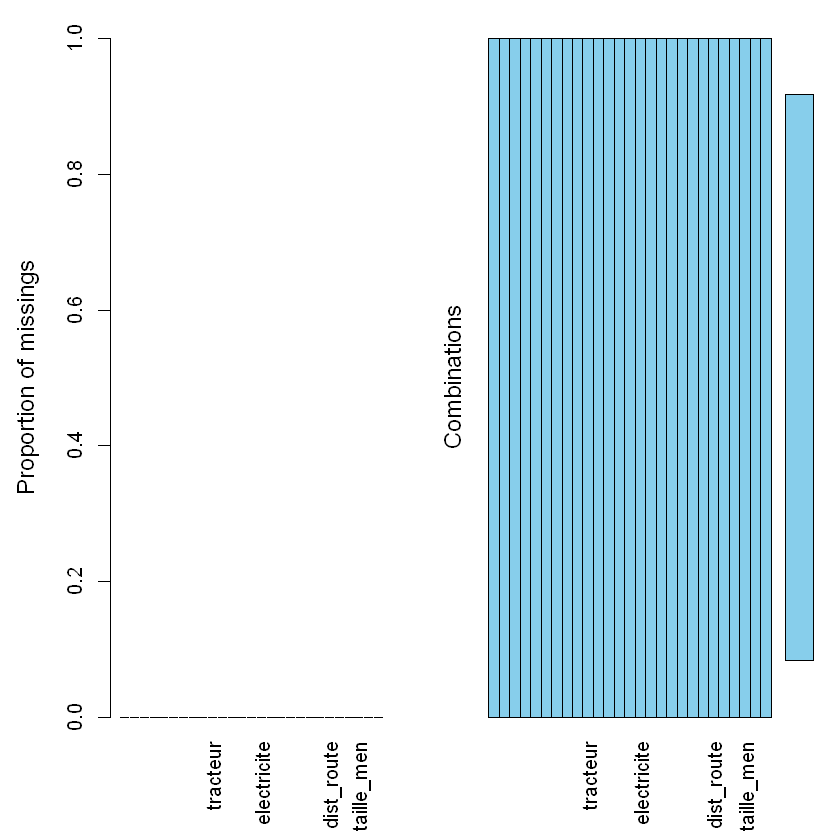

In [22]:
missr<-summary(aggr(df, sortVar=TRUE))$combinations

données sans les variabales avec le plus de variables manquantes

variables enregistrer les variables numériques et les valiables qualitatives

In [23]:
xquant<-dplyr::select_if(df, is.numeric)

xqual<-as.data.frame(unclass(dplyr::select_if(df,
         is.factor)),stringsAsFactors = TRUE)

In [24]:
df["tracteur"]<-(droplevels(df["tracteur"]))

- statistiques descriptives de base

In [25]:
summary(df)

  suptotculmen    personne_migr rev_tot_menage     part_rev_ele_tot 
 Min.   : 0.049   Min.   :0     Min.   :    2000   Min.   :0.00000  
 1st Qu.: 1.000   1st Qu.:0     1st Qu.: 2021875   1st Qu.:0.00000  
 Median : 2.000   Median :0     Median : 3527210   Median :0.00000  
 Mean   : 3.126   Mean   :1     Mean   : 6264999   Mean   :0.01618  
 3rd Qu.: 4.000   3rd Qu.:2     3rd Qu.: 7717750   3rd Qu.:0.00000  
 Max.   :25.800   Max.   :6     Max.   :88201248   Max.   :0.74608  
                                                                    
 part_rev_transf_tot part_rev_non_ag_tot part_rev_ag_tot   montan_global_credit
 Min.   :0.00000     Min.   :0.00000     Min.   :0.06604   Min.   :      0     
 1st Qu.:0.00000     1st Qu.:0.00000     1st Qu.:0.94223   1st Qu.:      0     
 Median :0.00000     Median :0.00000     Median :1.00000   Median :      0     
 Mean   :0.04742     Mean   :0.01318     Mean   :0.92321   Mean   :  91057     
 3rd Qu.:0.00000     3rd Qu.:0.00000     3rd Qu.

- analyse de la distribution des données quantitatives

hist(df$besoin_eau_total)
hist(log(df$besoin_eau_total))

part_rev_ag_tot

- analyse de la correlation entre les variables

corrplot 0.90 loaded



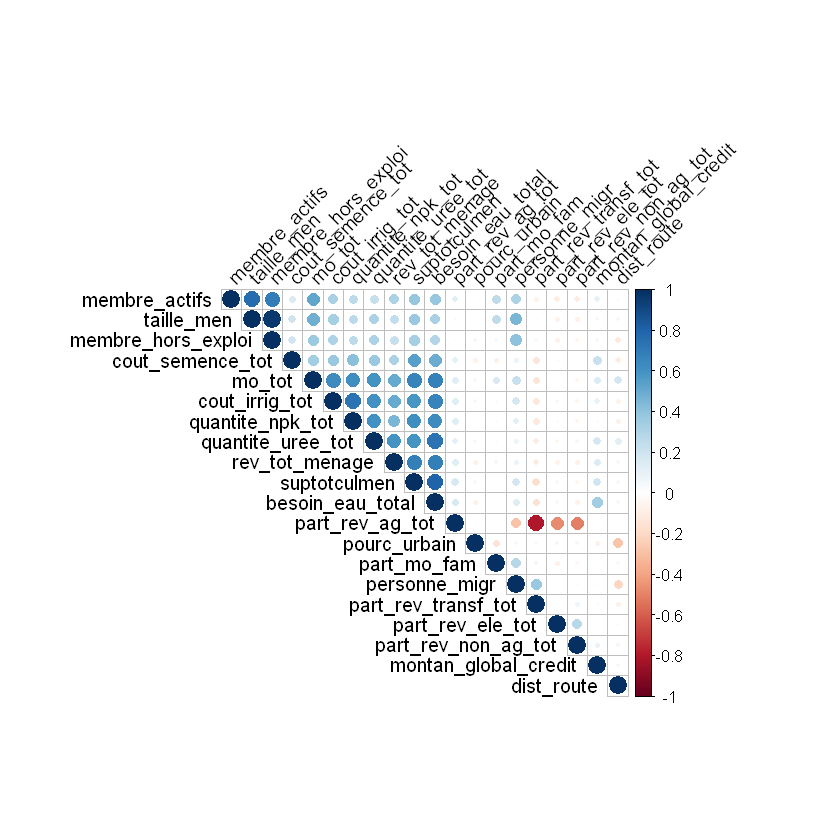

In [26]:
mtsup<-xquant
mcor <- cor(mtsup)
library(corrplot)
corrplot(mcor, type="upper", order="hclust", 
         tl.col="black", tl.srt=45)

- visualizing a correlation matrix using Multidimensional Scaling

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



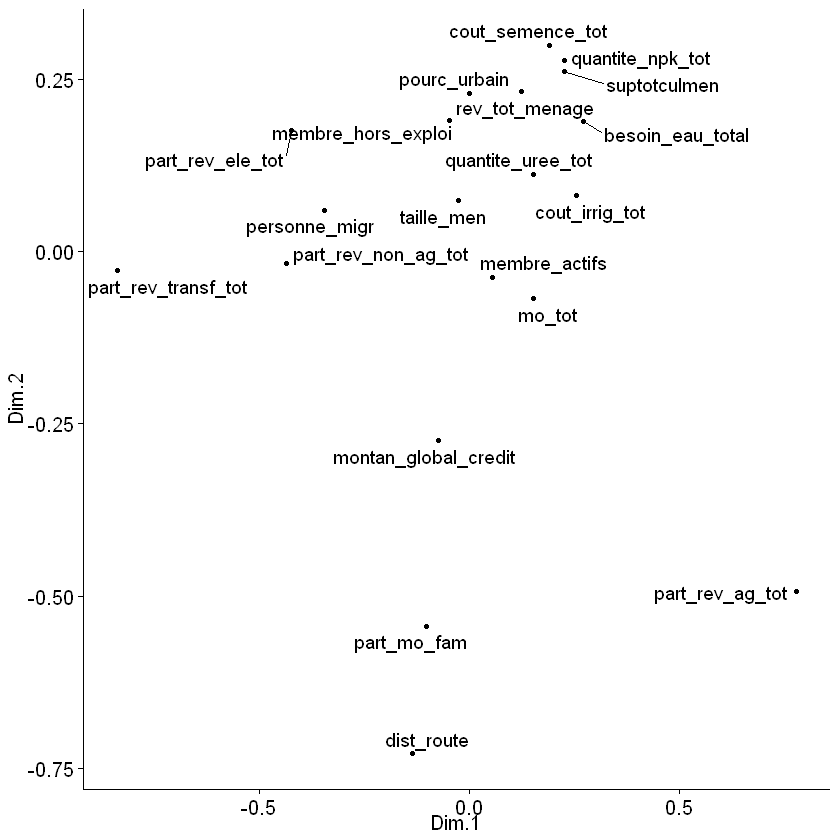

In [27]:
library(tidyverse)
library(ggpubr)

res.cor <- cor(xquant, method = "spearman")
mds.cor <- (1 - res.cor) %>%
  cmdscale() %>%
  as_tibble()
colnames(mds.cor) <- c("Dim.1", "Dim.2")
ggscatter(mds.cor, x = "Dim.1", y = "Dim.2", 
          size = 1,
          label = colnames(res.cor),
          repel = TRUE)

- analyse de la variabilité des facteurs quantitatifs

In [28]:
require(zoo)
datz <- zoo(xquant)

Le chargement a nécessité le package : zoo


Attachement du package : 'zoo'


Les objets suivants sont masqués depuis 'package:base':

    as.Date, as.Date.numeric




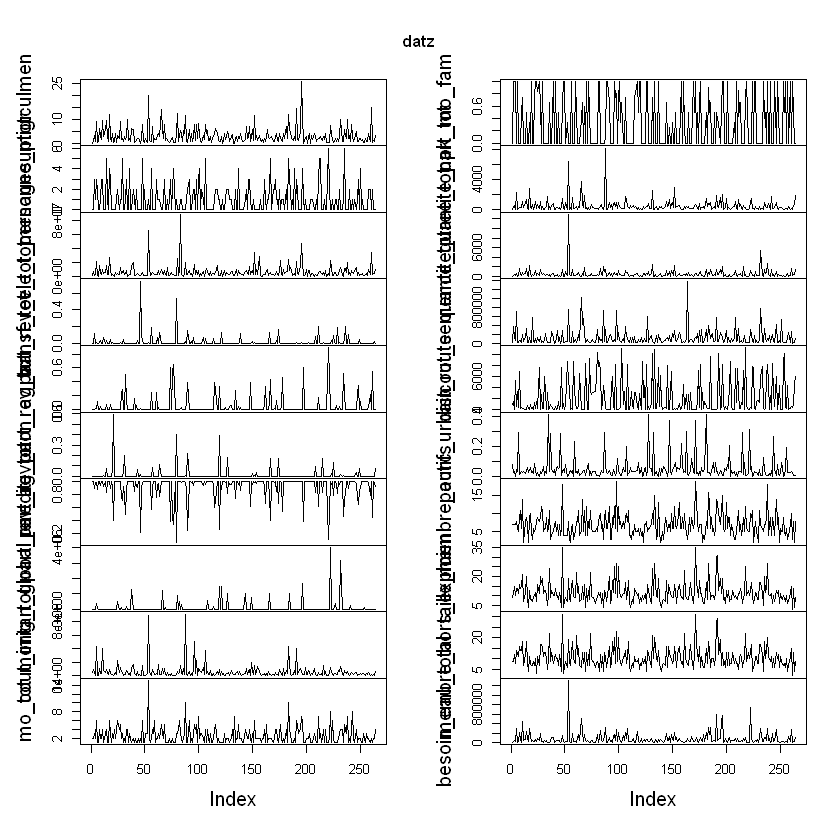

In [29]:
plot(datz)

- traitement des outliers

reperer les outliers

###### Multidimensional Scaling (MDS)

In [30]:
library("clusterSim")
library("psych")
library("MASS")
library("kmed")

Le chargement a nécessité le package : cluster

Le chargement a nécessité le package : MASS


Attachement du package : 'MASS'


L'objet suivant est masqué depuis 'package:dplyr':

    select



Attachement du package : 'psych'


Les objets suivants sont masqués depuis 'package:ggplot2':

    %+%, alpha




- trouver les variables: binaires, catégorielles et numériques

In [31]:
tp<-c()
for (i in 1:length(names(df))){
    if (is.numeric(df[,i])){
        tp[i]<-"num"
    }else{
        if (length(levels(df[,i]))>2){
            tp[i]<-"cat"
        }else{tp[i]<-"bin"}
    }
}

bin<-which(tp=="bin")
num<-which(tp=="num")
cat<-which(tp=="cat")

- projeter les variables dans une dimension réduite pour visualiser les Outliers

In [32]:
d1<-df
#rownames(d1) <- NULL

dist.df <- distmix(d1, method = "gower", idnum = num, idbin = bin,
  idcat = cat)

mds1 <- cmdscale(dist.df, k=9)

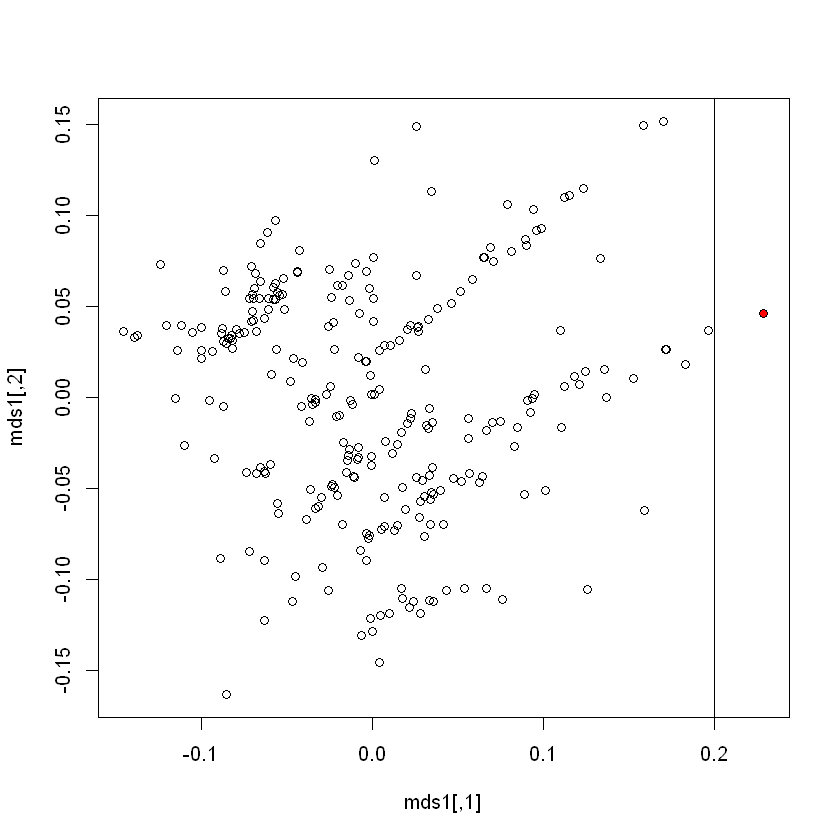

In [33]:
plot(mds1)

abline(v=0.2)
abline(h=0.2)

abline(v=-0.2)
abline(h=-0.2)

x1.out<-which(abs(mds1[,1])>0.2)
y1.out<-which(abs(mds1[,2])>0.2)

out1.all<-c(x1.out, y1.out)
out1.uni<-unique(out1.all)
D1<-d1[out1.uni,]

D1$x1.out<-mds1[out1.uni,1]
D1$y1.out<-mds1[out1.uni,2]
points(D1[,c("x1.out","y1.out")],
       pch=21, bg="red")

Nonmetric MDS

initial  value 23.449397 
iter   5 value 16.441875
iter  10 value 16.324542
iter  10 value 16.319411
iter  10 value 16.308487
final  value 16.308487 
converged


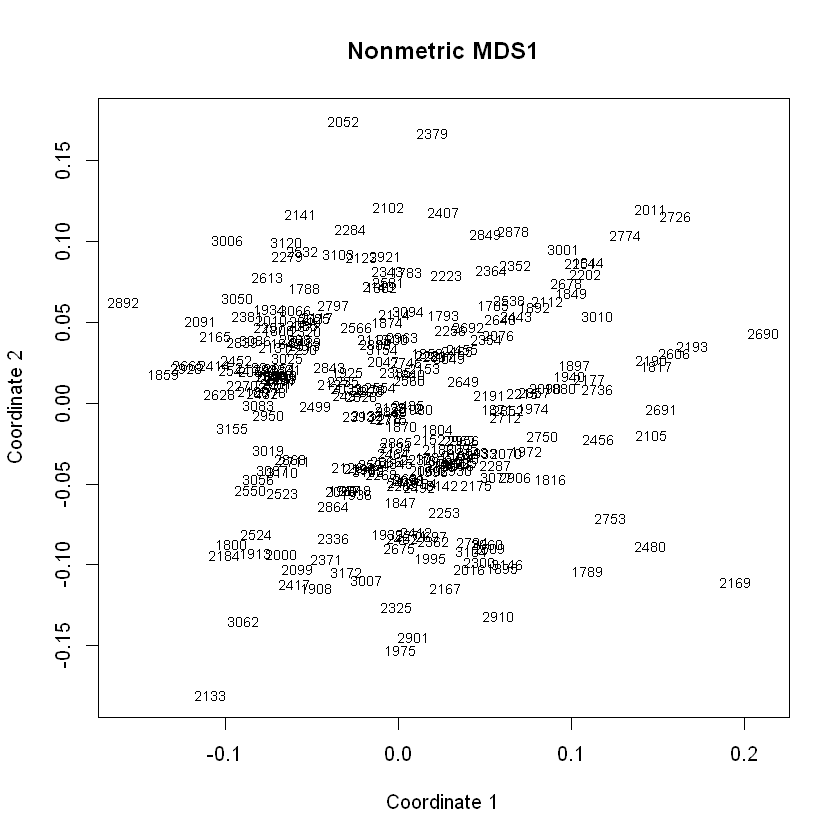

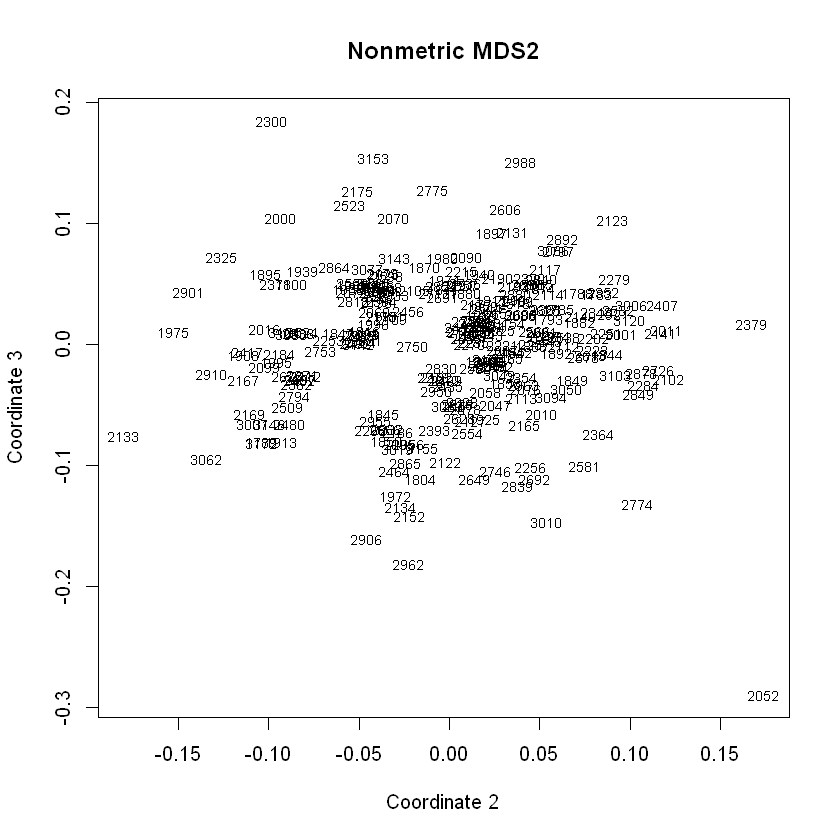

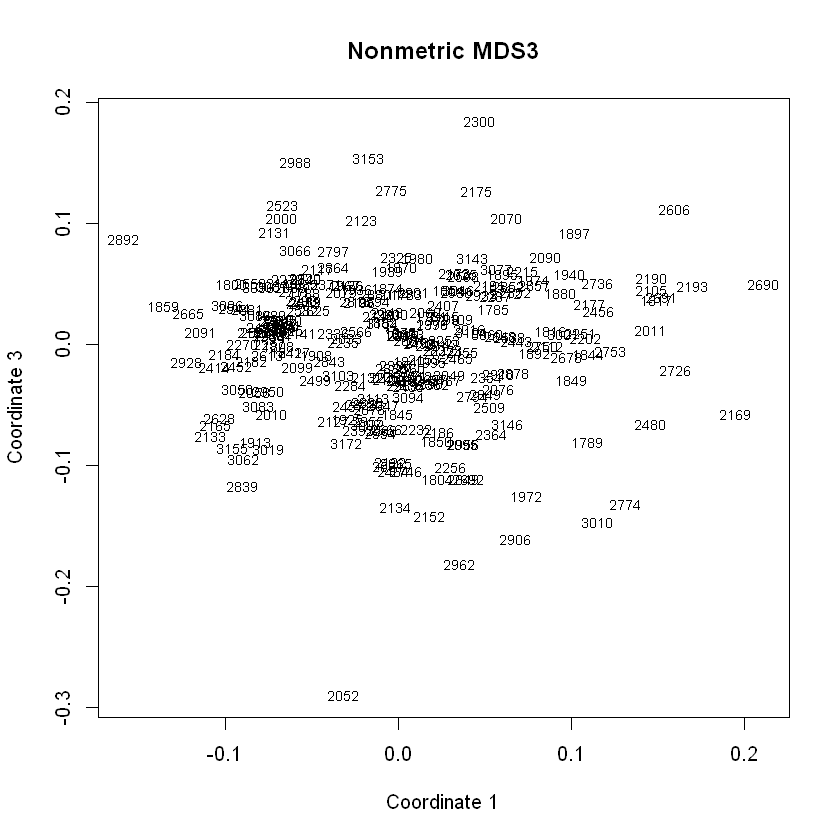

In [34]:
# Nonmetric MDS
# N rows (objects) x p columns (variables)
# each row identified by a unique row name

dist1.df <- distmix(d1, method = "gower", idnum = num, idbin = bin,
  idcat = cat) # distance matrix for a mixed data
fit <- isoMDS(dist1.df, k=3) # k is the number of dim
#fit # view results

# plot solution
x <- fit$points[,1]
y <- fit$points[,2]
z <- fit$points[,3]

plot(x, y, xlab="Coordinate 1", ylab="Coordinate 2",
  main="Nonmetric MDS1", type="n")
text(x, y, labels = row.names(df), cex=.7) 

plot(y, z, xlab="Coordinate 2", ylab="Coordinate 3",
  main="Nonmetric MDS2", type="n")
text(y, z, labels = row.names(df), cex=.7) 


plot(x, z, xlab="Coordinate 1", ylab="Coordinate 3",
  main="Nonmetric MDS3", type="n")

text(x, z, labels = row.names(df), cex=.7) 

initial  value 34.275827 
iter   5 value 25.412116
iter  10 value 25.097082
final  value 25.054400 
converged


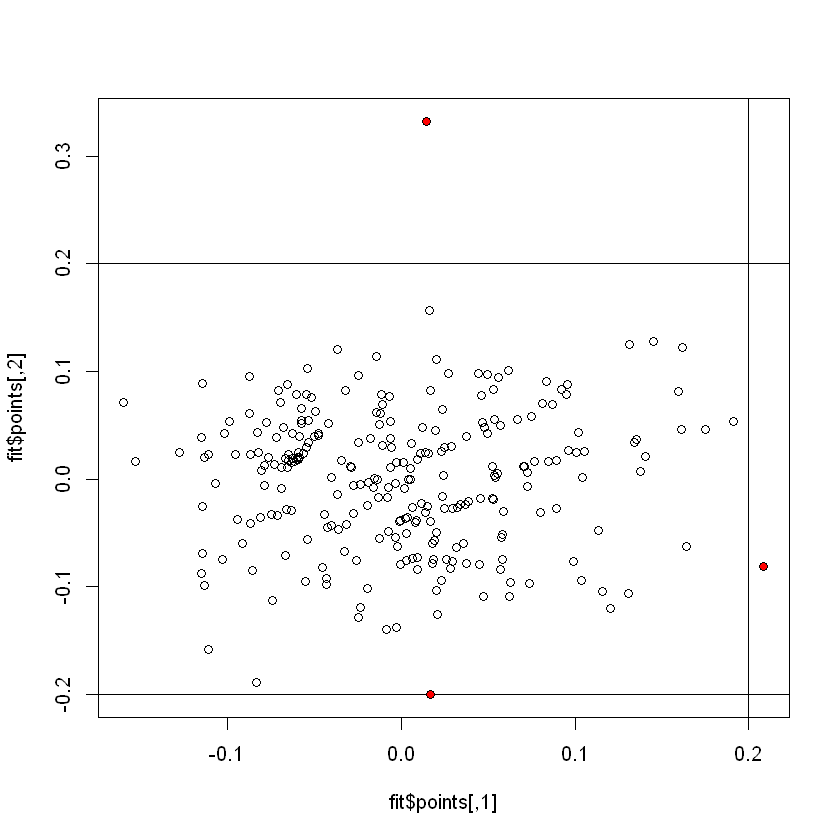

In [35]:
dist1.df <- distmix(d1, method = "gower", idnum = num, idbin = bin,
  idcat = cat) # distance matrix for a mixed data
fit <- isoMDS(dist1.df, k=2) # k is the number of dim
#fit # view results

plot(fit$points)

abline(v=0.2)
abline(h=0.2)

abline(v=-0.2)
abline(h=-0.2)

x.out<-which(abs(fit$points[,1])>0.2)
y.out<-which(abs(fit$points[,2])>0.2)

out.all<-c(x.out, y.out)
out.uni<-unique(out.all)

D<-data.frame(d1[out.uni,])
D$x.out<-unlist(fit$points[out.uni,1])
D$y.out<-unlist(fit$points[out.uni,2])

points(D[,c("x.out","y.out")],
       pch=21, bg="red")

- statistiques descriptives pour repérer et supprimer les outliers

In [36]:
row.names(d1[out1.uni,])
row.names(d1[out.uni,])

[1] "2690"

[1] "2169" "2052" "2300"

Un certain nombre de variables deviennent moins utiles après avoir retirer les Outliers puisqu'elles sont nulles

In [37]:
dist.au<-dist1.df
city.names<-row.names(d1)

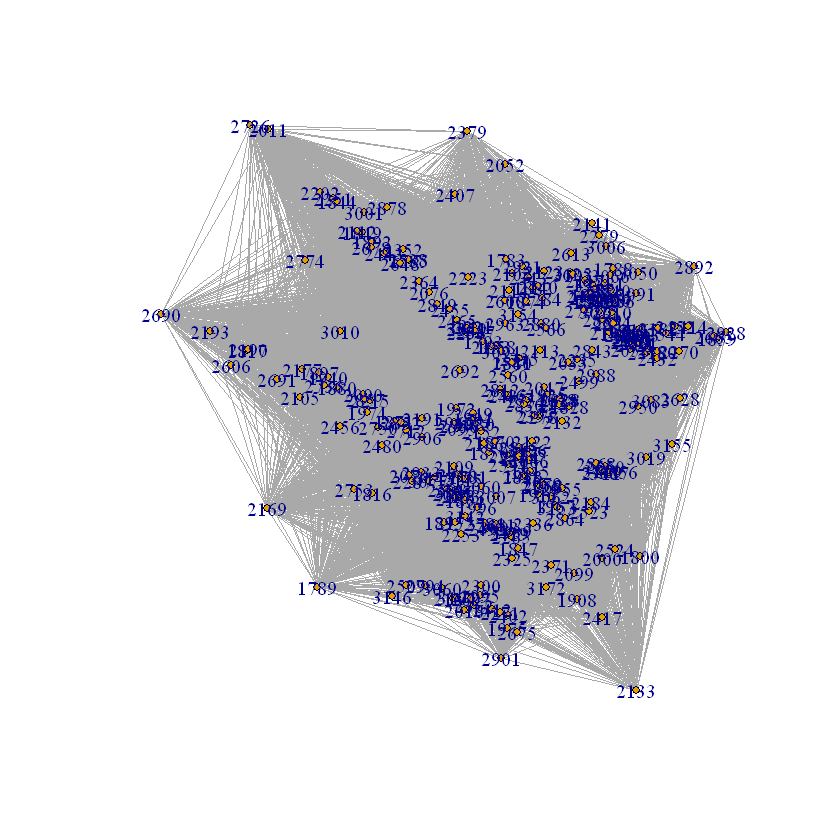

In [73]:
library(igraph)
g <- graph.full(nrow(dist.au))
V(g)$label <- city.names
layout <- layout.mds(g, dist = as.matrix(dist.au))
plot(g, layout = layout, vertex.size = 3)

##### préparation à postiori des données

In [39]:
base<-df
#base<-df[which(df$suptotculmen>0.4),]
#base<-df[which(row.names(df)!=outl),]

In [40]:
dim(base)

#264-251=13

[1] 264  27

- convertir la surface d'hectare en m2

- garantir l'unicité des modalités

In [41]:
for (i in names(base[,(colnames(base) %in% qual)])){
    
    base[,i]<-sub("^",
            paste(i,"=",sep=""),base[,i])
}

- log des variables numériques

- valeurs relatives à la surface de certaines varibales

In [42]:
to_ratio<-c('cout_irrig_tot','mo_tot','quantite_npk_tot',
           'quantite_uree_tot','cout_semence_tot',
           'besoin_eau_total')


for (i in to_ratio){
    
    base[i]<-(base[i]/base['suptotculmen'])
}

- valeurs des varibales de démographie des ménage rapportée à la taille ds ménages

In [43]:
to_ratio_men<-c('personne_migr','membre_actifs',
                'membre_hors_exploi')


for (i in to_ratio_men){
    
    base[i]<-(base[i]/base['taille_men'])
}

- log-nomarilsation de certaines varibales par la surface totale

In [44]:
to_norm<-c('rev_tot_menage','part_rev_ele_tot',
  'part_rev_transf_tot','part_rev_non_ag_tot',
  'montan_global_credit','dist_route','pourc_urbain',
   to_ratio_men,to_ratio)

In [45]:
base$suptotculmen<-log(base$suptotculmen)

In [46]:
for (i in to_norm){
    base[i]<-log(base[i]+1)
}

- vérification de problème d'échelles

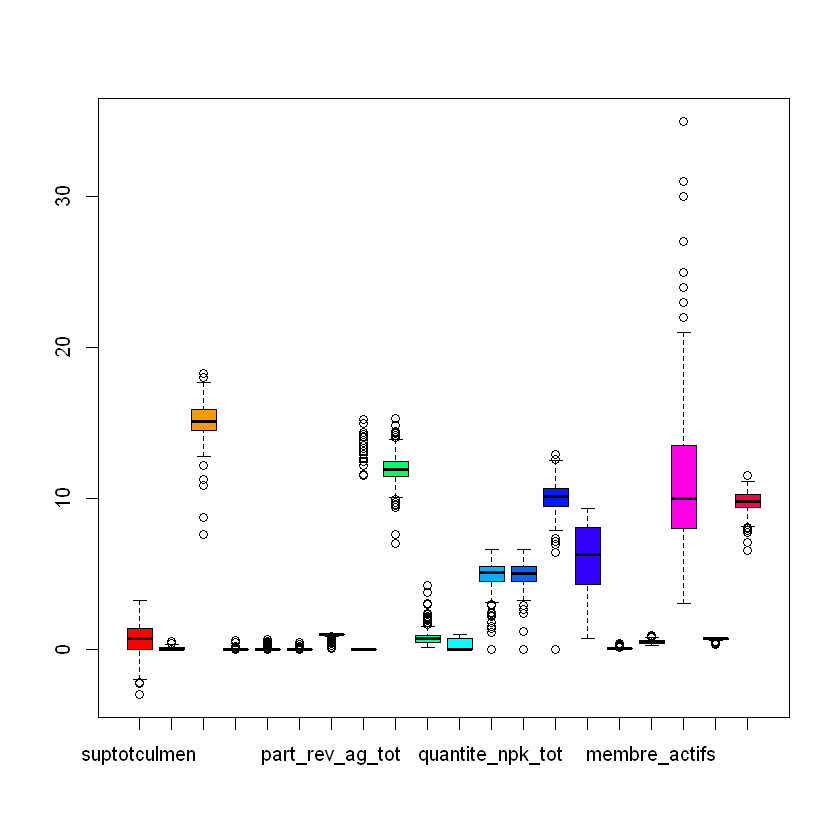

In [47]:
bn<-dplyr::select_if(base, is.numeric)
boxplot(bn,col = rainbow(ncol(bn)))

on voit qu'il y a une net différence d'échelle qui écrase certaines distributions. On va faire appelle à une standardisation (centré et réduire les obs) pour palier à cela.

- standardiser les variables numériques

In [48]:
library(quantable)

loading package quantable



In [49]:
for (i in names(base[,!(colnames(base) %in% qual)])){
    
    base[i]<-as.numeric(scale(base[i], 
                    center = TRUE,
                    scale = TRUE))
}

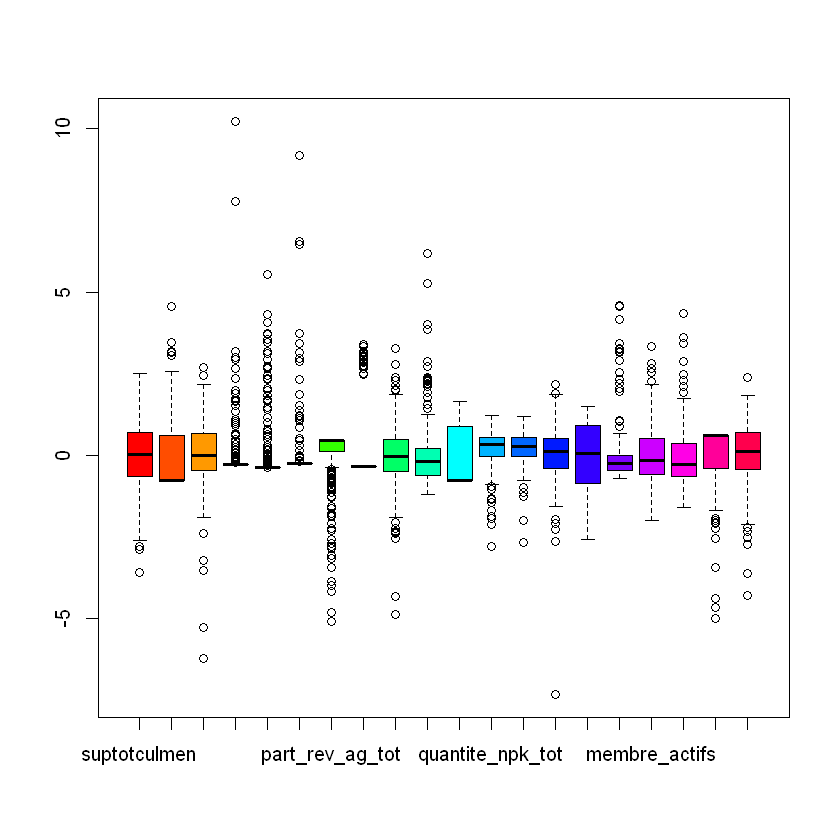

In [50]:
bn1<-dplyr::select_if(base, is.numeric)
boxplot(bn1,col = rainbow(ncol(bn1)))

1-suptotculmen, 2-personne_migr 3-rev_tot_menage, 4-part_rev_ele_tot,

5-part_rev_transf_tot, 5-part_rev_non_ag_tot, 6-part_rev_ag_tot,

7-montan_global_credit, 8-cout_irrig_tot, 9-mo_tot, 10-part_mo_fam, 

11-quantite_npk_tot, 12-quantite_uree_tot, 13-cout_semence_tot, 

14-dist_route, 15pourc_urbain, 16-membre_actifs, 17-taille_men,

18-membre_hors_exploi, 19-besoin_eau_total.

C'est mieux !!!

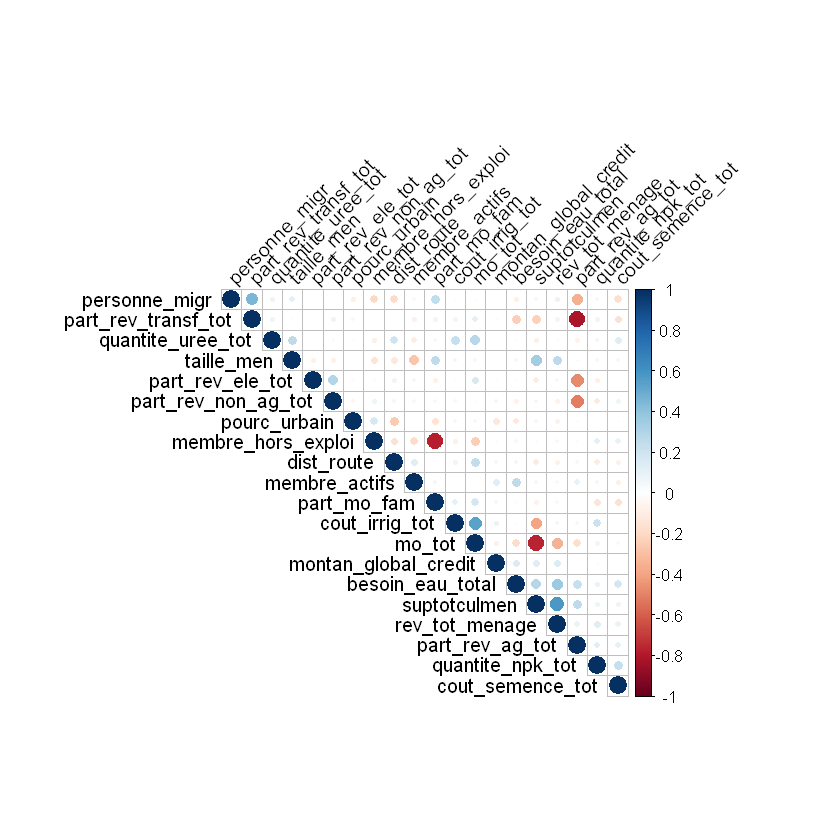

In [51]:
mcor2 <- cor(bn1)
library(corrplot)
corrplot(mcor2, type="upper", order="hclust", 
         tl.col="black", tl.srt=45)

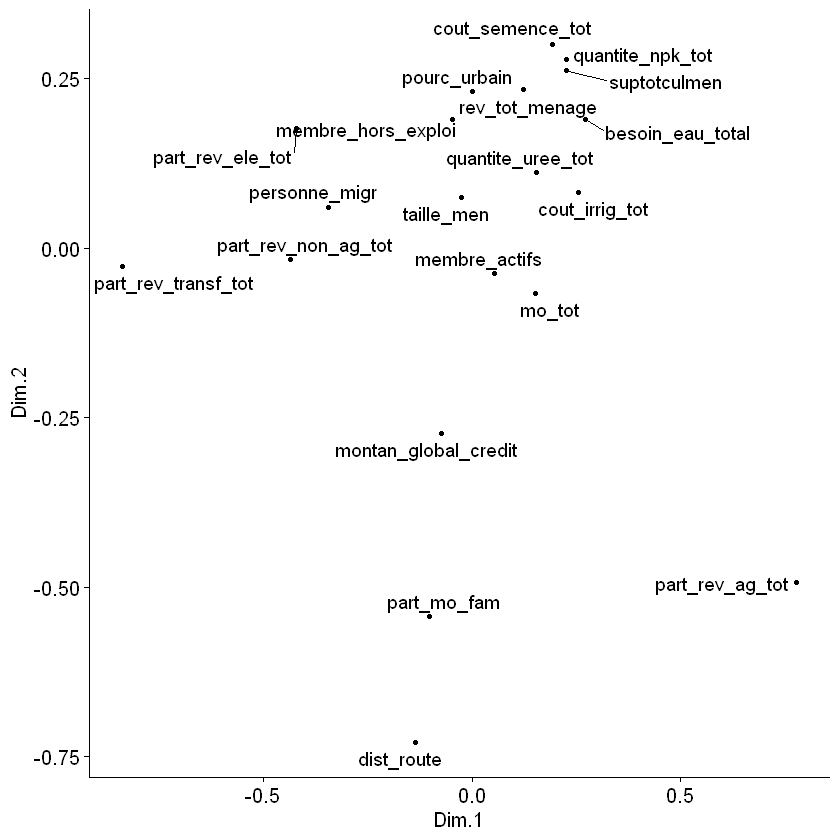

In [52]:
library(tidyverse)
library(ggpubr)

res.cor1 <- cor(bn1, method = "spearman")
mds.cor1 <- (1 - res.cor) %>%
  cmdscale() %>%
  as_tibble()
colnames(mds.cor1) <- c("Dim.1", "Dim.2")
ggscatter(mds.cor1, x = "Dim.1", y = "Dim.2", 
          size = 1,
          label = colnames(res.cor1),
          repel = TRUE)

In [53]:
stop!

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: '!' inattendu(e)
1: stop!
        ^


### II- CLASSIFICATION

### 2.1- l'analyse factorielle des données mixtes avec classification hiérachique (AFDM + CAH)

In [ ]:
library("FactoMineR")
library("factoextra")

In [ ]:
res.famd <- FAMD(base, graph = FALSE,ncp=33)
fviz_screeplot(res.famd,addlabels = TRUE)

In [ ]:
eig.val <- get_eigenvalue(res.famd)
#eig.val
head(eig.val,10)

In [ ]:
res.famd <- FAMD(base, graph = FALSE,ncp = 5)

In [ ]:
quanti.var <- get_famd_var(res.famd, "quanti.var")
quali.var <- get_famd_var(res.famd, "quali.var")

In [ ]:
# Graphique des variables
fviz_famd_var(res.famd, col.var="cos2", alpha.var="contrib",
gradient.cols = c("blue", "green", "red"), repel = TRUE)

# Graphique des variables
fviz_famd_var(res.famd, col.var="cos2", alpha.var="contrib",
gradient.cols = c("blue", "green", "red"), 
              repel = TRUE,axes=c(2,3))

# Graphique des variables
fviz_famd_var(res.famd, col.var="cos2", alpha.var="contrib",
gradient.cols = c("blue", "green", "red"),
              repel = TRUE,axes=c(3,4))

# Graphique des variables
fviz_famd_var(res.famd, col.var="cos2", alpha.var="contrib",
gradient.cols = c("blue", "green", "red"),
              repel = TRUE,axes=c(4,5))

In [ ]:
fviz_famd_var(res.famd, "quanti.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE)

fviz_famd_var(res.famd, "quanti.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE,axes=c(2,3))

fviz_famd_var(res.famd, "quanti.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE,axes=c(3,4))

fviz_famd_var(res.famd, "quanti.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE,axes=c(4,5))

In [ ]:
fviz_famd_var(res.famd, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")
             )

fviz_famd_var(res.famd, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800",
                               "#FC4E07"),axes=c(2,3)
             )

fviz_famd_var(res.famd, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800",
                               "#FC4E07"),axes=c(3,4)
             )

fviz_famd_var(res.famd, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800",
                               "#FC4E07"),axes=c(4,5)
             )

In [ ]:
fviz_pca_ind(res.famd, col.ind = "cos2", 
             gradient.cols = c("#00AFBB",
             "#E7B800", "#FC4E07"),
             repel = TRUE)

fviz_pca_ind(res.famd, col.ind = "cos2", 
             gradient.cols = c("#00AFBB",
             "#E7B800", "#FC4E07"),
             repel = TRUE,axes=c(2,3))

fviz_pca_ind(res.famd, col.ind = "cos2", 
             gradient.cols = c("#00AFBB",
             "#E7B800", "#FC4E07"),
             repel = TRUE,axes=c(3,4))

In [ ]:
fviz_mfa_ind(res.famd, 
             habillage = "arrosage_group_enc", # color by groups 
             palette = 1:4,repel = TRUE, # Avoid text overlapping
             ) 

fviz_mfa_ind(res.famd, 
             habillage = "arrosage_group_enc", # color by groups 
             palette = 1:4,repel = TRUE, # Avoid text overlapping
             axes=c(2,3)) 

fviz_mfa_ind(res.famd, 
             habillage = "arrosage_group_enc", # color by groups 
             palette = 1:4,repel = TRUE, # Avoid text overlapping
             ,axes=c(3,4)) 

In [ ]:
# classification
hc.famd <- HCPC(res.famd, graph = FALSE) #Si nb.clust = -1 : laisser le programme décider du nombre optimal de clusters.

In [ ]:
fviz_dend(hc.famd, 
          cex = 0.7,                     # Label size
          palette = "jco",               # Color palette see ?ggpubr::ggpar
          rect = TRUE, rect_fill = TRUE, # Add rectangle around groups
          rect_border = "jco",           # Rectangle color
          labels_track_height = 0.8      # Augment the room for labels
          )

In [ ]:
fviz_cluster(hc.famd,
             repel = TRUE,            # Avoid label overlapping
             show.clust.cent = TRUE, # Show cluster centers
             palette = "jco",         # Color palette see ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
             )

In [ ]:
# Principal components + tree
plot(hc.famd, choice = "3D.map")

In [ ]:
hc.famd$desc.var$quanti

In [ ]:
hc.famd$desc.axes$quanti

In [ ]:
hc.famd$desc.ind$para

In [ ]:
# Description by variables
hc.famd$desc.var$test.chi2

In [ ]:
# Description by variable categories
hc.famd$desc.var$category

In [ ]:
df.clust<-df
base.clust<-base

df.clust$clust<-hc.famd$data.clust$clust
base.clust$clust<-hc.famd$data.clust$clust

In [ ]:
stat_clust<-data.frame(sapply(df.clust[(names(df.clust)%in%names(xquant))],stat.comp ,y=df.clust$clust))
stat_clust<-round(stat_clust,2)
t(stat_clust)

In [ ]:
# Load the library
library(randomForest)
library(data.table)
library(caret)

In [ ]:
set.seed(123)
# Create random forest
# For classification
base.clust.rf <- randomForest(clust ~ ., 
                        data = base.clust, 
                        importance = TRUE,
                        proximity = TRUE)

print(base.clust.rf)
plot(base.clust.rf)

In [ ]:
varImpPlot(base.clust.rf,type=1)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$tracteur), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$relat_contract), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$source_eau), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$syst_exhaure_fin), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$souscrit_assurance), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$electricite), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.clust$arrosage_group_enc), 
                        unlist(df.clust$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
varImp(base.clust.rf)

In [ ]:
library(tidyverse)
library(caret)
library(glmnet)

# Dumy code categorical predictor variables
x <- model.matrix(clust~., base.clust)[,-1]

y=base.clust$clust

fit <- glmnet(x, y, family = "multinomial", type.multinomial = "grouped")
plot(fit, xvar = "lambda", label = TRUE, type.coef = "2norm")

set.seed(123)
cvfit <- cv.glmnet(x, y, family = "multinomial", type.multinomial = "grouped")
plot(cvfit)

coef(cvfit, cvfit$lambda.1se)

l<-coef(cvfit, cvfit$lambda.1se)
cd<-c()
for (i in 1:4){
    
    d<-data.frame(Reduce(rbind, l[[i]]))
    d[,2]<-rownames(l[[i]])
    names(d)<-c("coef","variables")
    rownames(d)<-NULL
    cd<-unique(c(cd,d[which(d$coef!=0),]$variables))[-1]
}
cd

### 2.2-  MSD clustering

In [ ]:
sw<-distmix(base, method = "gower", idnum = num, idbin = bin,
  idcat = cat)

##### 1- Classical MSD

#### 2- Non-metric MDS

In [ ]:
library(magrittr)
library(dplyr)
library(ggpubr)

- a-) Kruskal’s non-metric multidimensional scaling

- b-) Sammon’s non-linear mapping

In [ ]:
# Cmpute MDS
library(MASS)
mds <- sw %>%         
  sammon() %>%
  .$points %>%
  as_tibble()
colnames(mds) <- c("Dim.1", "Dim.2")
# Plot MDS
ggscatter(mds, x = "Dim.1", y = "Dim.2", 
          label = rownames(sw),
          size = 1,
          repel = TRUE)

In [ ]:
fviz_nbclust(mds, FUNcluster = cluster::pam, 
             method = c("silhouette"))

fviz_nbclust(mds, kmeans, method = c("silhouette"))

In [ ]:
# K-means clustering
clust <- kmeans(mds, 4)$cluster %>%
  as.factor() 

mds <- mds %>%
  mutate(groups = clust)
# Plot and color by groups
ggscatter(mds, x = "Dim.1", y = "Dim.2", 
          label = rownames(sw),
          color = "groups",
          palette = "jco",
          size = 1, 
          ellipse = TRUE,
          ellipse.type = "convex",
          repel = TRUE)

In [ ]:
df.sammon<-df
df.sammon$clust<-clust

In [ ]:
stat_clust1<-data.frame(sapply(df.sammon[(names(df.sammon)%in%names(xquant))],
                               stat.comp ,y=df.sammon$clust))

stat_clust1<-round(stat_clust1,2)
t(stat_clust1)

In [ ]:
df.sammon.rf <- randomForest(clust ~ ., 
                        data = df.sammon, 
                        importance = TRUE,
                        proximity = TRUE)

varImpPlot(df.sammon.rf,type=1)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$tracteur), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$relat_contract), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$source_eau), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$syst_exhaure_fin), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$souscrit_assurance), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$electricite), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
    gmodels::CrossTable(unlist(df.sammon$arrosage_group_enc), 
                        unlist(df.sammon$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

In [ ]:
imp_df.sammon<-setDT(varImp(df.sammon.rf), keep.rownames = TRUE)[]
imp_df.sammon

### 2.3-  PCA CAMILLE

In [ ]:
var<-c("id",'suptotculmen','rev_tot_menage','cout_intrants_tot',
       'ratiosuploue_tot','ratio_irr_tot','nb_boeufs_vendus',
       'personne_migr','rev_non_ag','montan_global_credit',
       'rev_transfert','part_mo_fam','cout_semence_tot',
       "besoin_eau_total")

In [ ]:
df.cam<-(data[,(colnames(data) %in% var)])
#df.cam<-df.cam[which(row.names(df)!=outl),]
df.cam <- data.frame(df.cam[,-1], row.names = df.cam[,1])

In [ ]:
X<-cbind(df.cam,xqual)
pca_cam <- PCA(X,graph=FALSE,quali.sup=which(names(X)%in%names(xqual)))
pca_var_cam <- get_pca_var(pca_cam)

In [ ]:
fviz_screeplot(pca_cam,addlabels = TRUE)

In [ ]:
eig.val.pca <- get_eigenvalue(pca_cam)
#eig.val
head(eig.val.pca,3)

In [ ]:
pca_cam <- PCA(df.cam, graph = FALSE,ncp = 3)

In [ ]:
fviz_pca_var(pca_cam, col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE)

In [ ]:
fviz_pca_ind(pca_cam, col.ind = "cos2", 
             gradient.cols = c("#00AFBB",
             "#E7B800", "#FC4E07"),
             repel = TRUE)

In [ ]:
res.hcpc.pca <- HCPC(pca_cam, graph = FALSE)
fviz_dend(res.hcpc.pca, 
          cex = 0.7,                     # Taille du text
          palette = "jco",               # Palette de couleur ?ggpubr::ggpar
          rect = TRUE, rect_fill = TRUE, # Rectangle autour des groupes
          rect_border = "jco",           # Couleur du rectangle
          labels_track_height = 0.8      # Augment l'espace pour le texte
          )

In [ ]:
fviz_cluster(res.hcpc.pca,
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
             )

In [ ]:
# Principal components + tree
plot(res.hcpc.pca, choice = "3D.map")

In [ ]:
res.hcpc.pca$desc.ind

In [ ]:
res.hcpc.pca$desc.var$quanti

In [ ]:
cam.pca.clt<-X
cam.pca.clt$cluster<-res.hcpc.pca$data.clust$clust

In [ ]:
cam.pca.rf <- randomForest(cluster ~ ., 
                        data = na.omit(cam.pca.clt), 
                        importance = TRUE,
                        proximity = TRUE)

varImpPlot(cam.pca.rf,type=1)

### 2.4- sélection de variables de classification à partir d'une préclassification

- Analyse Factorielle des Données Mixtes

In [ ]:
library(factoextra)
library(FactoMineR)

analyse factorielle

In [ ]:
famd <- FAMD(base,graph=FALSE,ncp=33)
famdvar <- get_famd_var(famd)

fviz_famd_var(famd, col.var="cos2", alpha.var="contrib", gradient.cols = c("blue", "green", "red"), repel = TRUE)

In [ ]:
fviz_screeplot(famd,addlabels = TRUE)

In [ ]:
famd <- FAMD(base,graph=FALSE,ncp=6)

statistique de Hopkins sur les axes factirielles

In [ ]:
library(clustertend)
datafamd <- data.frame(res.famd$ind$coord)
hopkins(datafamd, n=100)

In [ ]:
get_clust_tendency(datafamd, 2, graph=F, gradient=list(low="red", mid="white", high="blue"))$hopkins_stat

- classification par la méthode des K-médoïdes (PAM)

nombre optimal de cluster

In [ ]:
fviz_nbclust(datafamd , FUNcluster = cluster::pam, method = c("silhouette"), k.max = 8, nboot = 100,)

k-médoide (PAM)

In [ ]:
set.seed(123)
pam8 <- eclust(datafamd, "pam", hc_metric="euclidean", k=4)

- c-) silouhette moyen des classes obtenus

In [ ]:
fviz_silhouette(pam8)

- d-) ajout des clusters obtenu à la base

In [ ]:
clt<-data.frame(as.factor(pam8$clustering))
names(clt)<-"cluster"
clt<-merge(df,clt, by = 0)
clt<-data.frame(clt, row.names = 1)

- e-) penalized Logistic Regression on naive FAMD cluster

In [ ]:
library(tidyverse)
library(caret)
library(glmnet)

In [ ]:
# Dumy code categorical predictor variables
x <- model.matrix(cluster~., clt)[,-1]

In [ ]:
y=clt$clust

In [ ]:
fit <- glmnet(x, y, family = "multinomial", type.multinomial = "grouped")
plot(fit, xvar = "lambda", label = TRUE, type.coef = "2norm")

In [ ]:
set.seed(123)
cvfit <- cv.glmnet(x, y, family = "multinomial", type.multinomial = "grouped")
plot(cvfit)

In [ ]:
coef(cvfit, cvfit$lambda.1se)

In [ ]:
l<-coef(cvfit, cvfit$lambda.1se)
cd<-c()
for (i in 1:4){
    
    d<-data.frame(Reduce(rbind, l[[i]]))
    d[,2]<-rownames(l[[i]])
    names(d)<-c("coef","variables")
    rownames(d)<-NULL
    cd<-unique(c(cd,d[which(d$coef!=0),]$variables))[-1]
}
cd

In [ ]:
df_num<-dplyr::select_if(df, is.numeric)

df_char<-as.data.frame(unclass(dplyr::select_if(df,
         is.factor)),stringsAsFactors = TRUE)

new_xquant<-df_num[(colnames(df_num) %in% cd)]
new_xqual<-df_char

- f-) distance de Glower

In [ ]:
library(cluster)
gow_data<-cbind(new_xquant,new_xqual)
d <- daisy(gow_data, metric="gower")

d.mat<-data.frame(as.matrix(d))

In [ ]:
fviz_nbclust(d.mat, FUNcluster = cluster::pam, 
             method = c("silhouette"))

fviz_nbclust(d.mat, FUNcluster = kmeans, 
             method = c("silhouette"))

In [ ]:
fit <- hclust(d=d, method="complete")    # Also try: method="ward.D"   
plot.new()
plot(fit, hang=-1)  

In [ ]:
# K-means clustering
clust <- kmeans(mds, 5)$cluster %>%
  as.factor() 

mds <- mds %>%
  mutate(groups = clust)
# Plot and color by groups
ggscatter(mds, x = "Dim.1", y = "Dim.2", 
          label = rownames(sw),
          color = "groups",
          palette = "jco",
          size = 1, 
          ellipse = TRUE,
          ellipse.type = "convex",
          repel = TRUE)

In [ ]:
library(JLutils)
best.cutree(fit, graph = TRUE, xlab = "Nombre de classes", ylab = "Inertie relative")

In [ ]:
kfit <- kmeans(d, 3)
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0)

In [ ]:
questionr::freq(kfit$cluster)

In [ ]:
gow_data$cluster<-kfit$cluster

In [ ]:
# Load the library
library(randomForest)

In [ ]:
set.seed(123)
# Create random forest
# For classification
gd.rf <- randomForest(cluster ~ ., 
                        data = gow_data, 
                        importance = TRUE,
                        proximity = TRUE)

print(gd.rf)
plot(gd.rf)

In [ ]:
varImpPlot(gd.rf,type=1)

In [ ]:
library(data.table)
imp<-setDT(varImp(gd.rf), keep.rownames = TRUE)[]
imp<-(imp[order(imp$Overall,decreasing = TRUE),])
imp

In [ ]:
sapply(gow_data[(names(gow_data)%in%names(new_xquant))],quantile)

In [ ]:
x<-data.frame(sapply(gow_data[(names(gow_data)%in%names(new_xquant))],stat.comp ,y =gow_data$cluster))
x<-round(x,2)
t(x)

In [ ]:
q<-data.frame(lapply(gow_data[(names(gow_data)%in%names(new_xqual))],function(x) as.factor(x)))

- g-)distance de glower alternative

In [ ]:
# Remove college name before clustering
gower_dist <- daisy(gow_data,
                    metric = "gower",
                    type = list(logratio = 3))

In [ ]:
gower_mat <- as.matrix(gower_dist)
# Output most similar pair
gow_data[
  which(gower_mat == min(gower_mat[gower_mat != min(gower_mat)]),
        arr.ind = TRUE)[1, ], ]

In [ ]:
# Output most dissimilar pair
gow_data[
  which(gower_mat == max(gower_mat[gower_mat != max(gower_mat)]),
        arr.ind = TRUE)[1, ], ]

In [ ]:
# Calculate silhouette width for many k using PAM

sil_width <- c(NA)

for(i in 2:10){
  
  pam_fit <- pam(gower_dist,
                 diss = TRUE,
                 k = i)
  
  sil_width[i] <- pam_fit$silinfo$avg.width
  
}

# Plot sihouette width (higher is better)

plot(1:10, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:10, sil_width)

In [ ]:
pam_fit <- pam(gower_dist, diss = TRUE, k = 4)

pam_results <- gow_data %>%
  mutate(cluster = pam_fit$clustering) %>%
  group_by(cluster) %>%
  do(the_summary = summary(.))

pam_results$the_summary

In [ ]:
library(Rtsne)
tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering),
         name = rownames(gow_data))

ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster))

In [ ]:
##### retour aux données initiales
clust.data.gow<-left_join(gow_data %>%
          mutate(name = rownames(gow_data)),
          tsne_data,by = 'name')
rownames(clust.data.gow)<-rownames(gow_data)

In [ ]:
questionr::freq(tsne_data$cluster)

In [ ]:
clust.data.gow$cluster

In [ ]:
library(Hmisc)

for (i in 1:3){
    o<-gow_data[which((gow_data["cluster"]==i)),
                (names(gow_data)%in%names(new_xqual))]
    
    o<-data.frame(lapply(o,function(x) as.factor(x)))
    
    print(i)
    print(Hmisc::describe(o))
}

## METHODE RETENUE

### 2.5- Clustering Variables and Respondents

In [54]:
library(ClustOfVar)

In [55]:
xquant1<-dplyr::select_if(base, is.numeric)

xqual1<-as.data.frame(unclass(dplyr::select_if(df,
         is.factor)),stringsAsFactors = TRUE)

In [57]:
for (i in names(xqual1)){
    
    xqual1[,i]<-sub("^",
            paste(i,"=",sep=""),xqual1[,i])
}

- classification des variables

In [60]:
X.quanti <- PCAmixdata::splitmix(base)$X.quanti
X.quali <- PCAmixdata::splitmix(base)$X.quali
tree <- hclustvar(X.quanti,X.quali)

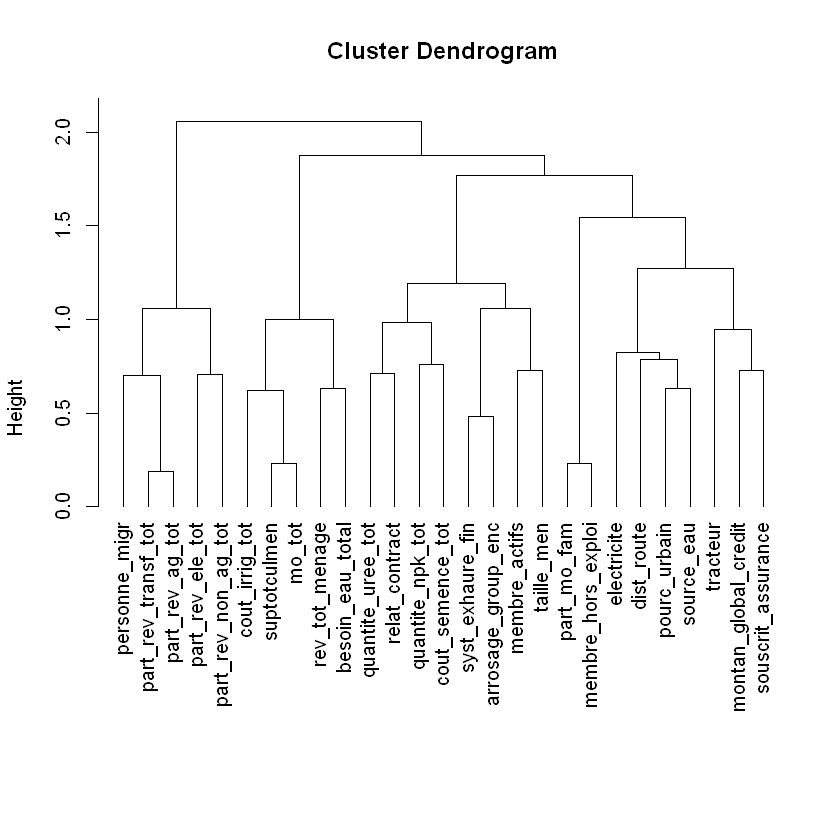

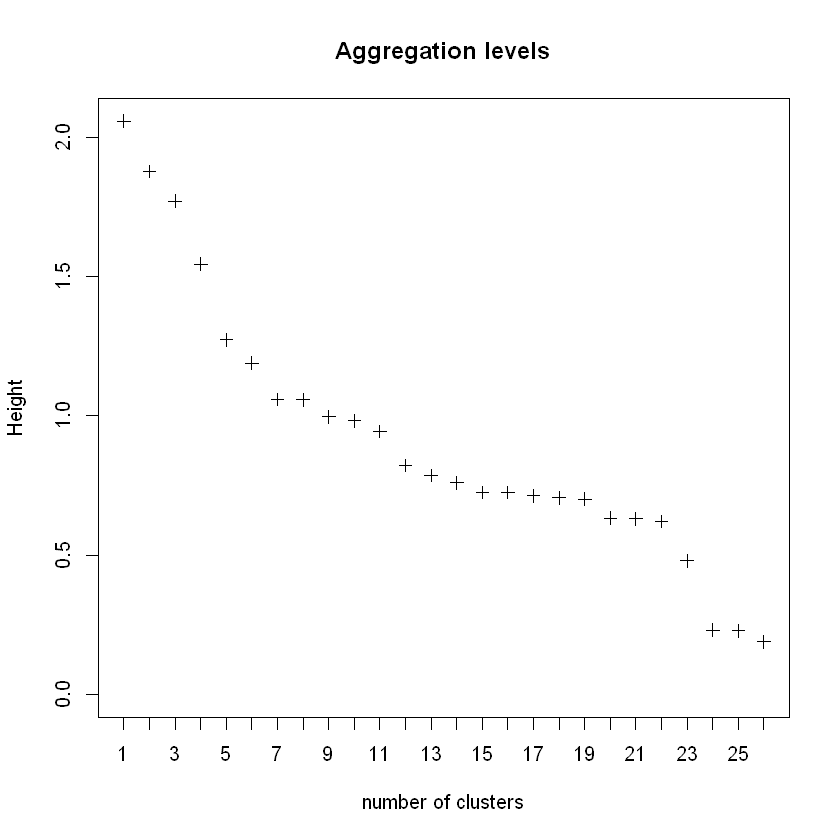

In [61]:
#tree <- hclustvar(xquant1, xqual1)
plot(tree)
plot(tree,type="index")

In [62]:
set.seed(123)


part_init<-cutreevar(tree,5)$cluster

k_var.means <- kmeansvar(xquant1, xqual1,
                         init=part_init,
                         )
summary(k_var.means)


Call:
kmeansvar(X.quanti = xquant1, X.quali = xqual1, init = part_init)

number of iterations:  2

Data: 
   number of observations:  264
   number of  variables:  27
        number of numerical variables:  20
        number of categorical variables:  7
   number of clusters:  5

Cluster  1 : 
                 squared loading correlation
suptotculmen               0.832        0.91
mo_tot                     0.736       -0.86
rev_tot_menage             0.442        0.67
cout_irrig_tot             0.304       -0.55
besoin_eau_total           0.194        0.44
tracteur                   0.027          NA


Cluster  2 : 
                    squared loading correlation
part_rev_ag_tot                0.96       -0.98
part_rev_transf_tot            0.63        0.80
personne_migr                  0.28        0.53
part_rev_non_ag_tot            0.26        0.51
part_rev_ele_tot               0.21        0.46


Cluster  3 : 
                     squared loading correlation
pourc_urbain        

In [98]:
k_var.means


Call:
kmeansvar(X.quanti = xquant1, X.quali = xqual1, init = part_init)

number of iterations:  2

 name      
 "$var"    
 "$sim"    
 "$cluster"
 "$wss"    
 "$E"      
 "$size"   
 "$scores" 
 "$coef"   
 description                                                                    
 "list of variables in each cluster"                                            
 "similarity matrix in each cluster"                                            
 "cluster memberships"                                                          
 "within-cluster sum of squares"                                                
 "gain in cohesion (in %)"                                                      
 "size of each cluster"                                                         
 "synthetic score of each cluster"                                              
 "coef of the linear combinations defining the synthetic scores of each cluster"

In [99]:
synt_var<-k_var.means$scores
head(synt_var,4)

,cluster1,cluster2,cluster3,cluster4,cluster5
1781,-6.00335064,-0.9118367,-0.74794504,-0.986554,-1.1179639
1783,-0.57976279,-0.9118367,0.61503864,1.784622,-2.1329686
1785,0.09458921,0.7515861,-0.09423379,1.896445,-1.2406510
1788,-0.54994270,-0.4071256,1.10292014,1.896445,-0.6243027


- choix du nombre de clusters

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



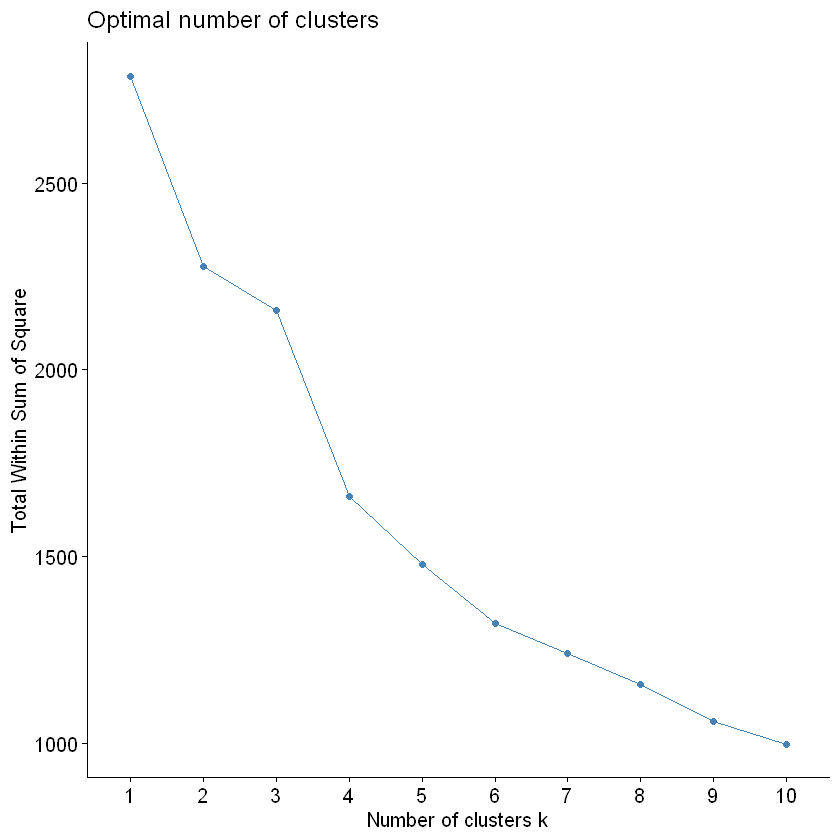

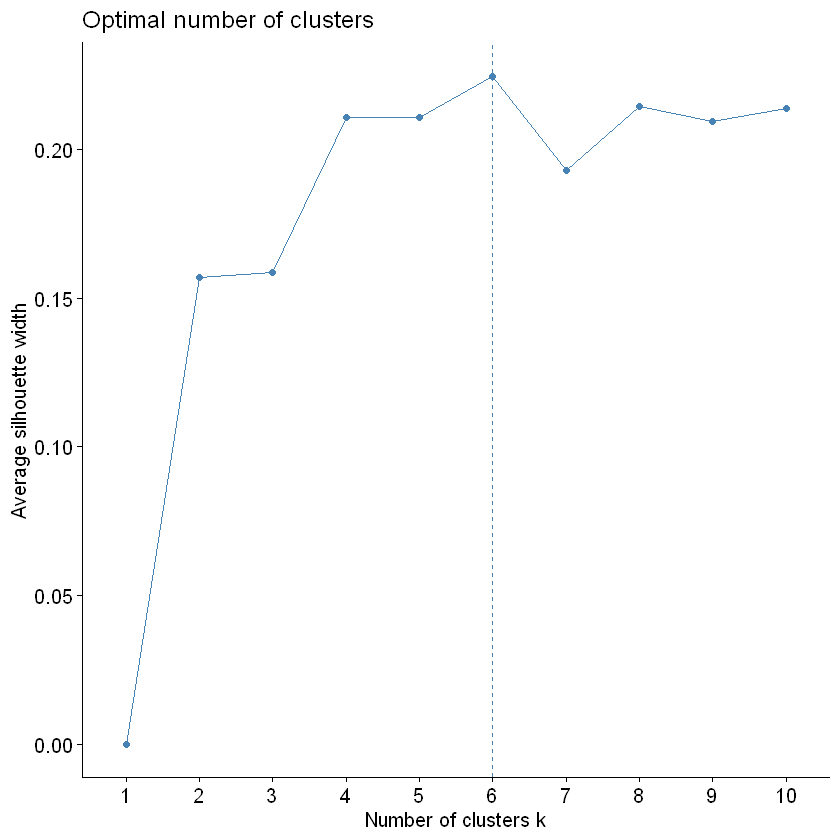

In [100]:
library("factoextra")

fviz_nbclust(synt_var, kmeans, method = "wss")

fviz_nbclust(synt_var, FUNcluster = kmeans, 
             method = c("silhouette"))

In [101]:
kmeans(synt_var, centers = 4, nstart = 25)

K-means clustering with 4 clusters of sizes 24, 55, 137, 48

Cluster means:
    cluster1   cluster2    cluster3   cluster4   cluster5
1 -1.1127346  4.1399511 -0.06034634  0.3129459  0.3693582
2  0.2273270 -0.6023181 -1.30934225 -0.6133027  1.3601247
3  0.7274112 -0.2659717  0.30439818 -0.2748804 -0.6494981
4 -1.7802643 -0.6206918  0.66165803  1.3308243  0.1106204

Clustering vector:
1781 1783 1785 1788 1789 1793 1800 1804 1808 1816 1817 1840 1842 1844 1845 1847 
   4    4    3    4    3    4    2    3    3    3    3    3    3    3    3    2 
1849 1850 1854 1858 1859 1870 1871 1874 1880 1882 1892 1895 1897 1908 1913 1925 
   3    3    4    3    1    4    3    4    4    4    3    3    1    2    3    1 
1934 1936 1939 1940 1967 1972 1974 1975 1980 1989 1995 1996 1998 2000 2010 2011 
   3    2    2    3    2    3    3    2    4    3    2    2    3    1    3    3 
2016 2025 2033 2047 2052 2058 2060 2070 2076 2078 2079 2085 2090 2091 2095 2099 
   4    4    3    4    3    2    3    1    3   

- classification par la distance de Gower

- classification suivant le Critère de Wald

,n,%,val%
,<dbl>,<dbl>,<dbl>
1,55,20.8,20.8
2,48,18.2,18.2
3,137,51.9,51.9
4,24,9.1,9.1


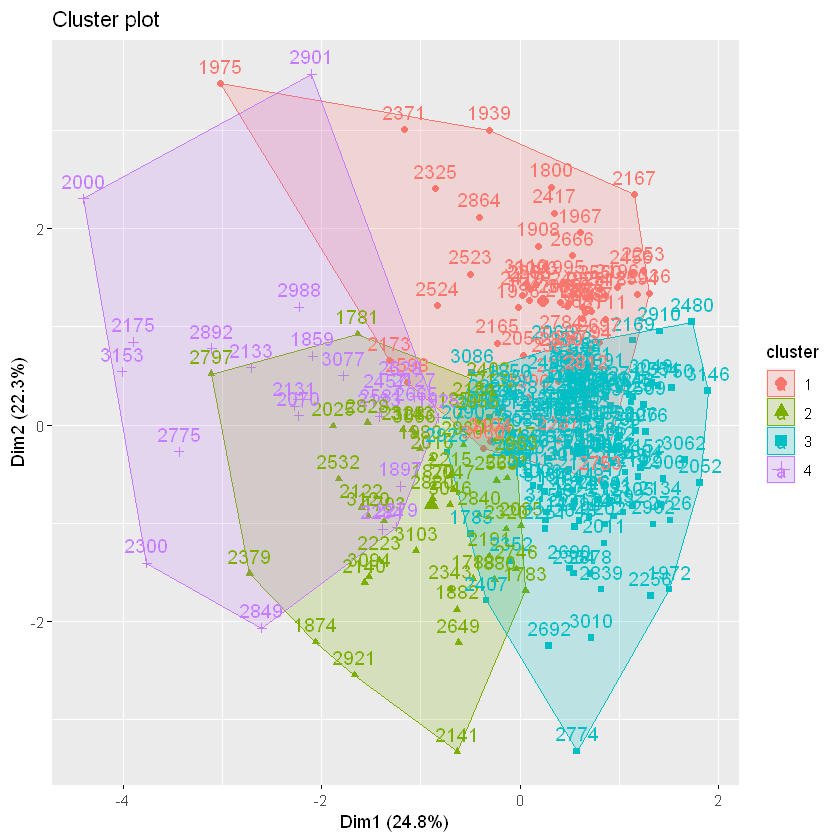

In [102]:
#plot results of final k-means model
k4<-kmeans(synt_var, centers = 4, nstart = 25)
fviz_cluster(k4,data = synt_var)
questionr::freq(k4$cluster)

- individus parangons

distance aux centroïdes

In [103]:
dtc<-data.frame(synt_var)
dtc$cluster<-k4$cluster
centre<-data.frame(k4$centers)

for (i in 1:dim(dtc)[1]){
    
    for (j in 1:4){
        if(dtc[i,"cluster"]==j){
          dtc[i,"dist_centroid"]<-dist(rbind(dtc[i,1:5],centre[j,]))[1]
        }
    }
}

individus qui minimisent la distance aux centroïds

In [104]:

X<-dtc
X$id<-row.names(X)
para<-X %>% 
    group_by(cluster) %>% 
    arrange(dist_centroid) %>%
    slice_head(n=4)

para <- data.frame(para[,-8], row.names = para$id)
para[,c("cluster","dist_centroid")]

,cluster,dist_centroid
,<int>,<dbl>
3093,1,0.5230032
2115,1,0.6973560
2265,1,0.9705104
2818,1,1.0289882
2880,2,0.3896385
3046,2,0.7567487
2047,2,1.1445684
2840,2,1.2101753
1840,3,0.7926879


- Random forest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : 'randomForest'


L'objet suivant est masqué depuis 'package:psych':

    outlier


L'objet suivant est masqué depuis 'package:dplyr':

    combine


L'objet suivant est masqué depuis 'package:ggplot2':

    margin





Call:
 randomForest(formula = cluster ~ ., data = var_clt4, importance = TRUE,      proximity = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 9

          Mean of squared residuals: 0.2300221
                    % Var explained: 72.89


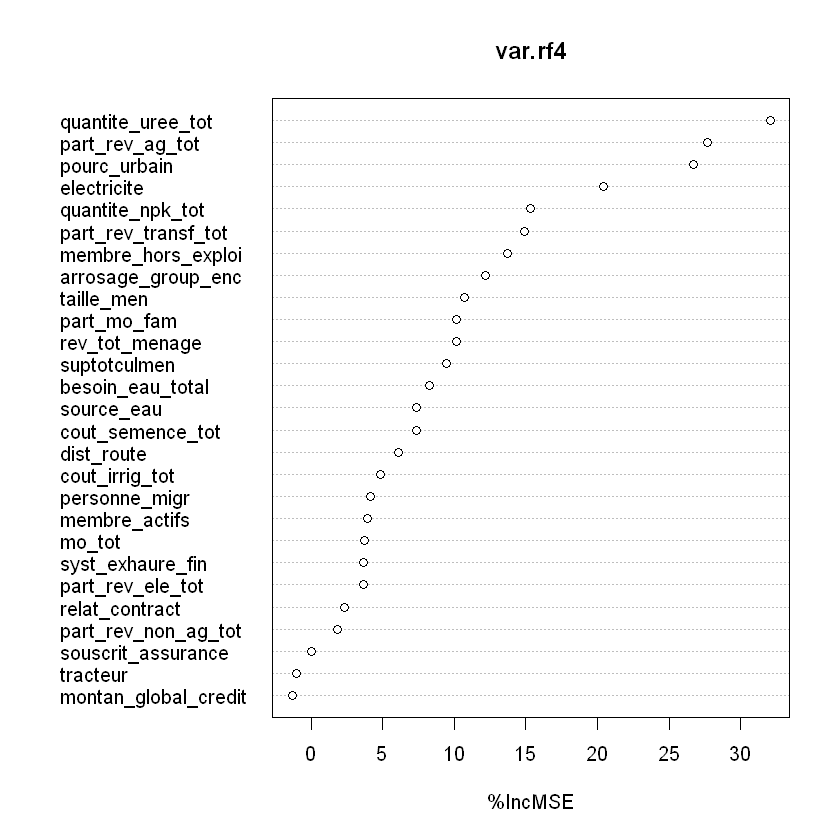

In [105]:
library(randomForest)

var_clt4<-cbind(xquant, xqual)
var_clt4$cluster<-k4$cluster

set.seed(123)
# Create random forest
# For classification
var.rf4 <- randomForest(cluster ~ ., 
                        data = var_clt4, 
                        importance = TRUE,
                        proximity = TRUE)
print(var.rf4)

varImpPlot(var.rf4,type=1)


Call:
 randomForest(formula = cluster ~ ., data = v, importance = TRUE,      proximity = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 0.2405559
                    % Var explained: 71.65


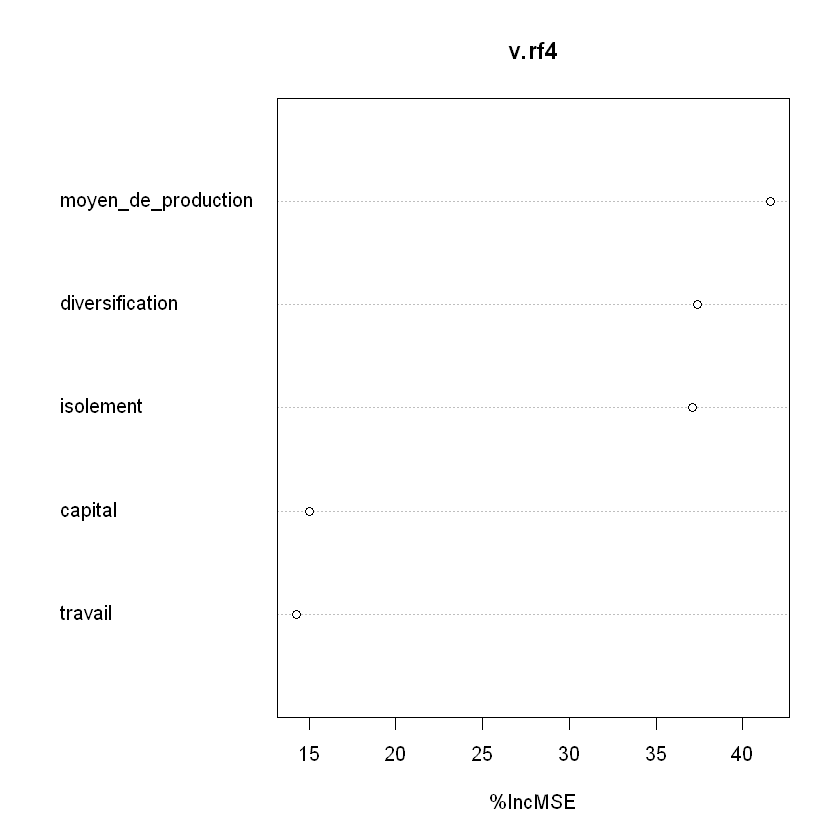

In [106]:
library(randomForest)

v<-data.frame(synt_var)
v$cluster<-k4$cluster
names(v)<-c("capital","diversification","isolement",
           "travail","moyen_de_production","cluster")

set.seed(123)
# Create random forest
# For classification
v.rf4 <- randomForest(cluster ~ ., 
                        data = v, 
                        importance = TRUE,
                        proximity = TRUE)
print(v.rf4)

varImpPlot(v.rf4,type=1)

- individus paragons

In [107]:
var_clt4

,suptotculmen,personne_migr,rev_tot_menage,part_rev_ele_tot,part_rev_transf_tot,part_rev_non_ag_tot,part_rev_ag_tot,montan_global_credit,cout_irrig_tot,mo_tot,⋯,membre_hors_exploi,besoin_eau_total,relat_contract,tracteur,source_eau,syst_exhaure_fin,souscrit_assurance,electricite,arrosage_group_enc,cluster
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
1781,0.1000000,0,1000000,0.000000000,0.000000000,0.000000000,1.0000000,0,438400,2,⋯,9,351.60,Non,Non,puits,Mecanique,Non,oui,Mixte,2
1783,1.2500000,0,6850000,0.000000000,0.000000000,0.000000000,1.0000000,0,880000,2,⋯,9,28105.50,Non,Non,puits,Manuel_et_Mecanique,Non,non,Mixte,2
1785,3.5000000,3,1810000,0.109392263,0.000000000,0.000000000,0.8906077,0,714000,3,⋯,12,48264.00,Non,Non,puits,Mecanique,Non,non,Mixte,3
1788,1.0000000,1,2670463,0.000000000,0.018723348,0.000000000,0.9812766,0,120000,2,⋯,8,23532.00,Non,Non,puits,Manuel_et_Mecanique,Non,non,Manuel,2
1789,9.1751499,3,20858000,0.011746093,0.009588647,0.000000000,0.9786652,400000,4290000,6,⋯,14,293613.44,Non,Non,forage,Mecanique,Non,oui,Mecanique,3
1793,0.5000000,2,1940000,0.000000000,0.123711340,0.000000000,0.8762887,100000,88000,1,⋯,13,3176.10,Non,Non,puits,Mecanique,Non,non,Mecanique,2
1800,0.7022936,0,486500,0.000000000,0.000000000,0.000000000,1.0000000,0,120000,1,⋯,11,12182.64,Non,Non,ceane,Manuel_et_Mecanique,Non,oui,Manuel,1
1804,6.2833333,0,15468000,0.003232480,0.000000000,0.000000000,0.9967675,0,1155000,4,⋯,16,219421.99,Non,Non,forage,Mecanique,Non,non,Mecanique,3
1808,3.4000001,1,6195000,0.032284100,0.038740922,0.000000000,0.9289750,0,384000,2,⋯,14,84779.50,Non,Non,puits,Manuel,Non,non,Manuel,3


In [108]:
k4$centers

,cluster1,cluster2,cluster3,cluster4,cluster5
1,0.2273270,-0.6023181,-1.30934225,-0.6133027,1.3601247
2,-1.7802643,-0.6206918,0.66165803,1.3308243,0.1106204
3,0.7274112,-0.2659717,0.30439818,-0.2748804,-0.6494981
4,-1.1127346,4.1399511,-0.06034634,0.3129459,0.3693582


   - Description des class sur les Exploitations

In [109]:
x_var4<-data.frame(sapply(var_clt4[(names(var_clt4)%in%(names(xquant)))],
                          stat.comp ,y =var_clt4$cluster))

x_var4<-round(x_var4,2)
t(x_var4)

,G 1,G 2,G 3,G 4,% epl.
suptotculmen,2.87,1.04,4.26,1.41,15.48
personne_migr,0.38,0.54,1.21,2.12,13.31
rev_tot_menage,5997345.00,2492788.96,8280951.00,2915067.71,7.32
part_rev_ele_tot,0.00,0.00,0.01,0.08,11.21
part_rev_transf_tot,0.01,0.01,0.02,0.38,62.60
part_rev_non_ag_tot,0.01,0.00,0.01,0.08,14.24
part_rev_ag_tot,0.98,0.99,0.96,0.46,77.89
montan_global_credit,30909.09,32208.33,140824.82,62500.00,1.75
cout_irrig_tot,374025.09,355004.17,831359.85,185395.83,6.22
mo_tot,1.85,2.44,2.96,2.04,6.08


In [110]:
    gmodels::CrossTable(unlist(var_clt4$tracteur), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)

Registered S3 method overwritten by 'gdata':
  method         from  
  reorder.factor gplots




 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                          | unlist(var_clt4$clust) 
unlist(var_clt4$tracteur) |         1 |         2 |         3 |         4 | Row Total | 
--------------------------|-----------|-----------|-----------|-----------|-----------|
                      Non |        55 |        48 |       131 |        24 |       258 | 
                          |     0.208 |     0.182 |     0.496 |     0.091 |           | 
--------------------------|-----------|-----------|-----------|-----------|-----------|
                      Oui |         0 |         0 |         6 |         0 |         6 | 
                          |     0.000 |     0.000 |     0.023 |     0.000 |           | 
--------------------------|-----------|-----------|-----------|-----------|-----------|
             Column Total |        55 |        48 |       137 |   

In [111]:
    gmodels::CrossTable(unlist(var_clt4$relat_contract), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                                | unlist(var_clt4$clust) 
unlist(var_clt4$relat_contract) |         1 |         2 |         3 |         4 | Row Total | 
--------------------------------|-----------|-----------|-----------|-----------|-----------|
                            Non |        52 |        48 |       137 |        24 |       261 | 
                                |     0.197 |     0.182 |     0.519 |     0.091 |           | 
--------------------------------|-----------|-----------|-----------|-----------|-----------|
                            Oui |         3 |         0 |         0 |         0 |         3 | 
                                |     0.011 |     0.000 |     0.000 |     0.000 |           | 
--------------------------------|-----------|-----------|-----------|-----------|-----------|
            

In [112]:
    gmodels::CrossTable(unlist(var_clt4$source_eau), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                            | unlist(var_clt4$clust) 
unlist(var_clt4$source_eau) |         1 |         2 |         3 |         4 | Row Total | 
----------------------------|-----------|-----------|-----------|-----------|-----------|
                      ceane |         7 |         0 |         0 |         2 |         9 | 
                            |     0.027 |     0.000 |     0.000 |     0.008 |           | 
----------------------------|-----------|-----------|-----------|-----------|-----------|
                  cours_eau |         2 |         0 |         3 |         0 |         5 | 
                            |     0.008 |     0.000 |     0.011 |     0.000 |           | 
----------------------------|-----------|-----------|-----------|-----------|-----------|
                     forage |         8 |       

ERROR: Error in fisher.test(t, alternative = "two.sided"): FEXACT erreur 6 (f5xact).  LDKEY=621 est trop petit pour ce problème : kval=9252341.
Essayez d’augmenter la taille de l’environnement de travail.


In [113]:
    gmodels::CrossTable(unlist(var_clt4$syst_exhaure_fin), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                                  | unlist(var_clt4$clust) 
unlist(var_clt4$syst_exhaure_fin) |         1 |         2 |         3 |         4 | Row Total | 
----------------------------------|-----------|-----------|-----------|-----------|-----------|
                           Manuel |        10 |         5 |        22 |         7 |        44 | 
                                  |     0.038 |     0.019 |     0.083 |     0.027 |           | 
----------------------------------|-----------|-----------|-----------|-----------|-----------|
              Manuel_et_Mecanique |         3 |         9 |        29 |         1 |        42 | 
                                  |     0.011 |     0.034 |     0.110 |     0.004 |           | 
----------------------------------|-----------|-----------|-----------|-----------|-------

In [114]:
    gmodels::CrossTable(unlist(var_clt4$souscrit_assurance), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                                    | unlist(var_clt4$clust) 
unlist(var_clt4$souscrit_assurance) |         1 |         2 |         3 |         4 | Row Total | 
------------------------------------|-----------|-----------|-----------|-----------|-----------|
                                Non |        55 |        48 |       136 |        23 |       262 | 
                                    |     0.208 |     0.182 |     0.515 |     0.087 |           | 
------------------------------------|-----------|-----------|-----------|-----------|-----------|
                                Oui |         0 |         0 |         1 |         1 |         2 | 
                                    |     0.000 |     0.000 |     0.004 |     0.004 |           | 
------------------------------------|-----------|-----------|-----------|-

In [115]:
    gmodels::CrossTable(unlist(var_clt4$electricite), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                             | unlist(var_clt4$clust) 
unlist(var_clt4$electricite) |         1 |         2 |         3 |         4 | Row Total | 
-----------------------------|-----------|-----------|-----------|-----------|-----------|
                         non |         8 |        34 |       101 |        14 |       157 | 
                             |     0.030 |     0.129 |     0.383 |     0.053 |           | 
-----------------------------|-----------|-----------|-----------|-----------|-----------|
                         oui |        47 |        14 |        36 |        10 |       107 | 
                             |     0.178 |     0.053 |     0.136 |     0.038 |           | 
-----------------------------|-----------|-----------|-----------|-----------|-----------|
                Column Total |        5

In [116]:
    gmodels::CrossTable(unlist(var_clt4$arrosage_group_enc), 
                        unlist(var_clt4$clust), 
                        prop.t=T,prop.r=F, 
                        prop.c=F,prop.chisq=F,
                        fisher=T,chisq=T)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  264 

 
                                    | unlist(var_clt4$clust) 
unlist(var_clt4$arrosage_group_enc) |         1 |         2 |         3 |         4 | Row Total | 
------------------------------------|-----------|-----------|-----------|-----------|-----------|
                      Goutte_goutte |         5 |         3 |         0 |         0 |         8 | 
                                    |     0.019 |     0.011 |     0.000 |     0.000 |           | 
------------------------------------|-----------|-----------|-----------|-----------|-----------|
                             Manuel |        18 |        16 |        47 |         9 |        90 | 
                                    |     0.068 |     0.061 |     0.178 |     0.034 |           | 
------------------------------------|-----------|-----------|-----------|-

ERROR: Error in fisher.test(t, alternative = "two.sided"): FEXACT erreur 6 (f5xact).  LDKEY=621 est trop petit pour ce problème : kval=5342000.
Essayez d’augmenter la taille de l’environnement de travail.


   - Description des class par Culture et par saison 

variables kasse

In [ ]:
var1.7<-c("producteur_ID","saison",
          "culture_label","var1","var4",
          "var5","var6","quant_eau_csc",
          "quant_eau_csf","var7",
          "eau_culture_csf","eau_culture_csc")

fusion des tables (kasse+base spatialisée)

In [ ]:
datt<-kasse[var1.7]

datt<-dplyr::left_join(datt,
                 var_clt4[c("cluster","suptotculmen")] %>%
                 mutate(producteur_ID = 
                 as.numeric(rownames(var_clt4["cluster"]))),
                 by = 'producteur_ID')

datt<-dplyr::left_join(datt,
                 data[c("capital","id")] %>%
                 mutate(producteur_ID =
                        as.numeric(as.character(data$id))),
                 by = 'producteur_ID')

names(datt)[which(names(datt)=="capital")]<-"capital_spatialise"

- unifier les variables eau

In [ ]:
datt$quant_eau<-ifelse(datt$saison=='CSC',datt$quant_eau_csc,datt$quant_eau_csf)
datt$eau_culture<-ifelse(datt$saison=='CSC',datt$eau_culture_csc,datt$eau_culture_csf)

renommer les variables

In [ ]:
names(datt)[which(var1.7=="var1"|
                 var1.7=="var4"|
                 var1.7=="var5"|
                 var1.7=="var6"|
                 var1.7=="var7")]<-
c("sup_emblavee_ha","quant_semence_kg",
 "quant_uree_kg","quant_npk_kg",
 "capital")

mettre les labels majuscules en minuscules

In [ ]:
datt$saison<-gsub(" ","_",tolower(datt$saison))

remplacer les espaces dans les labels

In [ ]:
datt$culture_label<-gsub(" ","_",
    tolower(datt$culture_label))

supprimer les colonnes inutiles/redondant

In [ ]:
datt<-datt[-which(names(datt)=='quant_eau_csc'|
                  names(datt)=='quant_eau_csf'|
                  names(datt)=="eau_culture_csf"|
                  names(datt)=="eau_culture_csc")]

datt<-na.omit(datt)
datt<-datt[-which(names(datt)=='id')]

calcul superficie verger

In [ ]:
datt$cumul_superficie<-ave(datt$sup_emblavee_ha,
                           datt$producteur_ID,
                           datt$saison,FUN=sum)

datt$surf_verger<-datt$suptotculmen-datt$cumul_superficie

supprimer les lignes/labels inutiles/redondants

In [ ]:
datt<-datt[-which(datt$culture_label=='aubergine_douce'),]

réécriture/correction des labels

In [ ]:
datt$culture_label<-gsub("carrotte","carotte",
                         datt$culture_label)

calcul des superfices en pourcentage

In [ ]:
datt$cumul_superficie<-ave(datt$sup_emblavee_ha,
                           datt$producteur_ID,
                           datt$saison,FUN=sum)

datt$pourcent_emblavee<-(datt$sup_emblavee_ha/datt$cumul_superficie)*100

datt[4:length(names(datt))]<-round(datt[4:length(names(datt))],2)

ajustement de la superficie emblavée

In [ ]:
sc<-datt$suptotculmen
se<-datt$sup_emblavee_ha
cs<-datt$cumul_superficie
vg<-datt$surf_verger

datt$sup_non_ajust<-datt$sup_emblavee_ha
datt$sup_emblavee_ha<-round(sc*(se/(cs+vg)),2)

- variables pour le calcul du revenu

In [ ]:
arch_data<-"archives/BASE  HORTICULTURE NIAYES VALLLEE-CLEAN"

rendement cultures: vf_8_Production

In [ ]:
var<-c("producteur_ID","culture_label",
       "saison","production_kg")

rendement_cult<-zap_labels(read_dta(file.path(arch_data,
                        "vf_8_Production.dta")))[var]

rendement_cult$saison<-gsub(" ","_",tolower(rendement_cult$saison))
rendement_cult$culture_label<-gsub(" ","_",
                tolower(rendement_cult$culture_label))

rendement_cult$culture_label<-gsub("carrotte","carotte",
                         rendement_cult$culture_label)

coût sement: vf_9_semence

In [ ]:
var<-c("producteur_ID","culture_label","saison",
       "prix_kg_seed")

cout_semence<-zap_labels(read_dta(file.path(arch_data,
                            "vf_9_semence.dta")))[var]

cout_semence<-na.omit(cout_semence)

cout_semence<-aggregate(cout_semence["prix_kg_seed"],
          FUN = sum,by = list(cout_semence$producteur_ID,
                              cout_semence$saison,
                              cout_semence$culture_label))

names(cout_semence)<-c("producteur_ID","culture_label",
                "saison","prix_kg_semence")

cout_semence$saison<-gsub(" ","_",tolower(cout_semence$saison))
cout_semence$culture_label<-gsub(" ","_",
                tolower(cout_semence$culture_label))

cout_semence$culture_label<-gsub("carrotte","carotte",
                         cout_semence$culture_label)

coût electricité irrigation: vf_0_producteur_id

In [ ]:
var<-c("producteur_ID","cultures_csf","cout_eau_csc",
       "cout_carburant_csc","cout_electricite_csc")

cout_electric<-zap_labels(read_dta(file.path(arch_data,
                        "vf_0_producteur_id.dta")))[var]

names(cout_electric)<-c("producteur_ID","culture_label",
                        "cout_eau_irrig","cout_carbur_irrig",
                        "cout_elect_irrig")

cout_electric$culture_label<-gsub(" ","_",
                tolower(cout_electric$culture_label))

cout_electric$culture_label<-gsub("carrotte","carotte",
                         cout_electric$culture_label)

engrais: vf_10_engrais

In [ ]:
npk<-read.csv2(file.path(arch_data,
            "npk_vf_10_engrais.csv"))

npk$saison<-gsub(" ","_",tolower(npk$saison))
npk$culture_label<-gsub(" ","_",
                        tolower(npk$culture_label))

npk<-npk[-4]

npk<-na.omit(npk)

npk<-aggregate(npk["prix_kg_engrais"],
          FUN = sum,by = list(npk$producteur_ID,
                              npk$saison,
                              npk$culture_label))

names(npk)<-c("producteur_ID","saison",
              "culture_label","prix_kg_npk")

npk$culture_label<-gsub("carrotte","carotte",
                         npk$culture_label)

In [ ]:
uree<-read.csv2(file.path(arch_data,
            "uree_vf_10_engrais.csv"))

uree$saison<-gsub(" ","_",tolower(uree$saison))
uree$culture_label<-gsub(" ","_",
                         tolower(uree$culture_label))

uree<-uree[-4]

uree<-na.omit(uree)

uree<-aggregate(uree["prix_kg_engrais"],
          FUN = sum,by = list(uree$producteur_ID,
                              uree$saison,
                              uree$culture_label))

names(uree)<-c("producteur_ID","saison",
              "culture_label","prix_kg_uree")

uree$culture_label<-gsub("carrotte","carotte",
                         uree$culture_label)

In [ ]:
engrais_org<-read.csv2(file.path(arch_data,
            "engrais_org_vf_10_engrais.csv"))

engrais_org$saison<-gsub(" ","_",tolower(engrais_org$saison))
engrais_org$culture_label<-gsub(" ","_",
                        tolower(engrais_org$culture_label))

engrais_org<-na.omit(engrais_org)

engrais_org<-aggregate(engrais_org[c("qte_kg_engrais",
                                  "prix_kg_engrais")],
          FUN = sum,by = list(engrais_org$producteur_ID,
                              engrais_org$saison,
                              engrais_org$culture_label))

names(engrais_org)<-c("producteur_ID","saison",
              "culture_label","qte_kg_engrais_org",
              "prix_kg_engrais_org")

engrais_org$culture_label<-gsub("carrotte","carotte",
                         engrais_org$culture_label)

insecticide: vf_11_phyto

In [ ]:
var<-c("producteur_ID","culture_label","saison",
       "qte_kg_insect","prix_insect","qte_kg_fong",
       "prix_fong","qte_kg_herb","prix_herb")

insecticide<-zap_labels(read_dta(file.path(arch_data,
                            "vf_11_phyto.dta")))[var]

insecticide$saison<-gsub(" ","_",
tolower(insecticide$saison))

insecticide$culture_label<-gsub(" ","_",
tolower(insecticide$culture_label))

insecticide$culture_label<-gsub("carrotte","carotte",
                         insecticide$culture_label)

charge intran et autre: vf_12_autres_charges

In [ ]:
var<-c("producteur_ID","culture","saison",
       "charges_tot","charge_transport_semence",
       "charge_transport_engrais","autres_charges_intr")

charge<-zap_labels(read_dta(file.path(arch_data,
                        "vf_12_autres_charges.dta")))[var]

charge<-aggregate(charge[c("charges_tot","charge_transport_semence",
                            "charge_transport_engrais",
                           "autres_charges_intr")],
          FUN = sum,by = list(charge$producteur_ID,
                              charge$saison,
                              charge$culture))


names(charge)<-c("producteur_ID","culture_label","saison",
       "charges_tot","charge_transport_semence",
       "charge_transport_engrais","autres_charges_intr")

charge$saison<-gsub(" ","_",
tolower(charge$saison))

charge$culture_label<-gsub(" ","_",
tolower(charge$culture_label))

charge$culture_label<-gsub("carrotte","carotte",
                         charge$culture_label)

vente de produit: vf_14.1_vente

In [ ]:
var<-c("producteur_ID","culture","saison",
       "prix_vente_indiv","quant_vend_indiv")

vente_ind<-zap_labels(read_dta(file.path(arch_data,
                        "vf_14.1_vente.dta")))[var]

vente_ind<-aggregate(vente_ind[c("prix_vente_indiv",
                                 "quant_vend_indiv")],
          FUN = mean,by = list(vente_ind$producteur_ID,
                              vente_ind$saison,
                              vente_ind$culture),
                     na.action = na.omit)

names(vente_ind)<-c("producteur_ID","culture_label",
                 "saison","prix_vente_indiv",
                 "quant_vend_indiv")

vente_ind$saison<-gsub(" ","_",
tolower(vente_ind$saison))

vente_ind$culture_label<-gsub(" ","_",
tolower(vente_ind$culture_label))

vente_ind$culture_label<-gsub("carrotte","carotte",
                         vente_ind$culture_label)

In [ ]:
var<-c("producteur_ID","culture","saison",
       "prix_vente_indiv","quant_vend_indiv")

vente_ind<-zap_labels(read_dta(file.path(arch_data,
                        "vf_14.1_vente.dta")))[var]

mean_prix<-aggregate(vente_ind[c("prix_vente_indiv")],FUN = mean,
          by =list(vente_ind$culture),na.rm=TRUE)

write.csv2(vente_ind,file.path(getwd(),"price_culture.csv"))

coût de commercialisation: vf_14.2_cout_commercialisation

In [ ]:
var<-c("producteur_ID","culture_label","saison",
       "cout_sac","cout_for_sac","cout_transport",
       "cout_stockage","quant_stockage")

cout_com<-zap_labels(read_dta(file.path(arch_data,
        "vf_14.2_cout_commercialisation.dta")))[var]

cout_com<-aggregate(cout_com[c("cout_sac","cout_for_sac",
                                "cout_transport","cout_stockage",
                                "quant_stockage")],
          FUN = sum,by = list(cout_com$producteur_ID,
                              cout_com$saison,
                              cout_com$culture_label))
names(cout_com)<-var

cout_com$saison<-gsub(" ","_",
tolower(cout_com$saison))

cout_com$culture_label<-gsub(" ","_",
tolower(cout_com$culture_label))

cout_com$culture_label<-gsub("carrotte","carotte",
                         cout_com$culture_label)

conso alimenatire: vf_15.2_consommation_alimentaire

In [ ]:
var<-c("producteur_ID","depense_achat")

cons_alim<-zap_labels(read_dta(file.path(arch_data,
        "vf_15.2_consommation_alimentaire.dta")))[var]

cons_alim<-na.omit(cons_alim)

cons_alim<-aggregate(cons_alim["depense_achat"],
          FUN = sum,by = list(cons_alim$producteur_ID))

names(cons_alim)<-c("producteur_ID","depense_achat_alimen")

conso non alimentaire: vf_15.3_consommation_non_alimentaire

In [ ]:
var<-c("producteur_ID","culture_label",
       "produits_non_alim","valeurestime_non_alim")

cons_non_alim<-zap_labels(read_dta(file.path(arch_data,
        "vf_15.3_consommation_non_alimentaire.dta")))[var]

cons_non_alim<-na.omit(cons_non_alim)

cons_non_alim<-aggregate(cons_non_alim["valeurestime_non_alim"],
          FUN = sum,by = list(cons_non_alim$producteur_ID,
                             cons_non_alim$culture_label))

names(cons_non_alim)<-c("producteur_ID","culture_label",
                        "estim_depense_non_alimen")

cons_non_alim$culture_label<-gsub(" ","_",
tolower(cons_non_alim$culture_label))

cons_non_alim$culture_label<-gsub("carrotte","carotte",
                         cons_non_alim$culture_label)

revenu de l'élevage: vf_19.1_autres_revenu_elevage

In [ ]:
var<-c("producteur_ID","montant_elev")

revenu_elev<-zap_labels(read_dta(file.path(arch_data,
        "vf_19.1_autres_revenu_elevage.dta")))[var]

revenu_elev<-na.omit(revenu_elev)

revenu_elev<-aggregate(revenu_elev["montant_elev"],
          FUN = sum,by = list(revenu_elev$producteur_ID))

names(revenu_elev)<-c("producteur_ID","rev_tot_elev")

revenus de la migration: vf_19.2_autres_revenus_migration

In [ ]:
var<-c("producteur_ID","montant_transfert")

revenu_migr<-zap_labels(read_dta(file.path(arch_data,
        "vf_19.2_autres_revenus_migration.dta")))[var]

revenu_migr<-na.omit(revenu_migr)

revenu_migr<-aggregate(revenu_migr["montant_transfert"],
          FUN = sum,by = list(revenu_migr$producteur_ID))

names(revenu_migr)<-var

autre revenu non agricole: vf_19.3_autres_revenus_non_agri

In [ ]:
var<-c("producteur_ID","montant_rev_nonagri")

rev_non_agri<-zap_labels(read_dta(file.path(arch_data,
        "vf_19.3_autres_revenus_non_agri.dta")))[var]

rev_non_agri<-na.omit(rev_non_agri)

rev_non_agri<-aggregate(rev_non_agri["montant_rev_nonagri"],
          FUN = sum,by = list(rev_non_agri$producteur_ID))

names(rev_non_agri)<-var

- fusion des tables de données

table par expoitation,culture et saison

In [ ]:
datt<-dplyr::left_join(datt,rendement_cult,c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,cout_semence,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,npk,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,uree,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,engrais_org,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,insecticide,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,charge,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,vente_ind,by=c('producteur_ID',"culture_label","saison"))

In [ ]:
datt<-dplyr::left_join(datt,cout_com,by=c('producteur_ID',"culture_label","saison"))

table par expoitation et culture

In [ ]:
datt<-dplyr::left_join(datt,cons_non_alim,by=c('producteur_ID',"culture_label"))

table par expoitation

In [ ]:
datt<-dplyr::left_join(datt,cout_electric,by='producteur_ID')
datt<-dplyr::left_join(datt,cons_alim,by='producteur_ID')
datt<-dplyr::left_join(datt,revenu_elev,by='producteur_ID')
datt<-dplyr::left_join(datt,revenu_migr,by='producteur_ID')
datt<-dplyr::left_join(datt,rev_non_agri,by='producteur_ID')  

- exportation de la base clusterée avec les variables d'intérêt

In [ ]:
write.csv2(datt,file.path(getwd(),"data_clust_rev.csv"))

- distributions

le capital

- Sup_emblavee_ha

- quant_semence_kg

- quant_uree_kg

- quant_npk_kg

- quant_eau_csc

- quant_eau_csf

In [ ]:
parangon